<a href="https://colab.research.google.com/github/Ishita95-harvad/CMI---Detect-Behavior-with-Sensor-Data/blob/main/submissionCell_notebookInfrastructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cmi_detect_behavior_with_sensor_data_path = kagglehub.competition_download('cmi-detect-behavior-with-sensor-data')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_inference_server.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/__init__.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/templates.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/base_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/relay.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/__init__.py
/kaggle/input/cmi-detect-behav

In [ ]:
# =============================================================================
# KAGGLE CODE COMPETITION SUBMISSION NOTEBOOK
# This cell must handle the entire pipeline for the hidden test set
# =============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path

# -----------------------------------------------------------------------------
# 1. LOAD DATA AND EXAMINE STRUCTURE
# -----------------------------------------------------------------------------
print("Loading competition data...")

# Get competition data directory
competition_data_path = Path('/kaggle/input/') / os.listdir('/kaggle/input/')[0]
print(f"Competition data path: {competition_data_path}")

# Load test data
test_df = pd.read_csv(competition_data_path / 'test.csv')
print(f"Test data shape: {test_df.shape}")
print(f"Test data columns: {test_df.columns.tolist()}")
print(f"Test data info:\n{test_df.info()}")
print(f"\nFirst few rows:\n{test_df.head()}")

# -----------------------------------------------------------------------------
# 2. EXAMINE DATA STRUCTURE AND IDENTIFY FEATURE COLUMNS
# -----------------------------------------------------------------------------
print("\nAnalyzing data structure...")

# Identify numerical columns (potential features)
numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numeric_cols}")

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Remove ID columns from feature candidates
feature_candidates = [col for col in numeric_cols if col not in ['sequence_id', 'row_id', 'id']]
print(f"Potential feature columns: {feature_candidates}")

# -----------------------------------------------------------------------------
# 3. ROBUST FEATURE ENGINEERING (works with any test data structure)
# -----------------------------------------------------------------------------
print("\nPerforming robust feature engineering...")

if feature_candidates:
    # If we have numerical columns, create statistical features
    test_additional_features = test_df.groupby('sequence_id')[feature_candidates].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).reset_index()

    # Flatten multi-level columns
    test_additional_features.columns = [
        f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
        for col in test_additional_features.columns
    ]
    print(f"Created statistical features from: {feature_candidates}")

else:
    # If no numerical columns, create sequence-based features
    print("No numerical columns found. Creating sequence-based features...")

    # Basic sequence features
    test_additional_features = test_df.groupby('sequence_id').agg({
        # Count number of rows per sequence
        test_df.columns[0]: 'count'
    }).reset_index()
    test_additional_features.columns = ['sequence_id', 'sequence_length']

    # Add more generic features
    test_additional_features['sequence_id_mod'] = test_additional_features['sequence_id'] % 10
    test_additional_features['constant_feature'] = 1.0

print(f"Additional features shape: {test_additional_features.shape}")
print(f"Additional features columns: {test_additional_features.columns.tolist()}")

# -----------------------------------------------------------------------------
# 4. MERGE FEATURES WITH TEST DATA
# -----------------------------------------------------------------------------
print("\nMerging features...")
test_df = pd.merge(test_df, test_additional_features, on='sequence_id', how='left')
print(f"Merged test data shape: {test_df.shape}")

# -----------------------------------------------------------------------------
# 5. LOAD YOUR TRAINED MODEL (Replace with your actual model loading)
# -----------------------------------------------------------------------------
print("\nLoading trained model...")
try:
    # REPLACE THIS WITH YOUR ACTUAL MODEL LOADING CODE
    # Example:
    # from joblib import load
    # model = load('/kaggle/working/your_trained_model.joblib')

    # For demonstration - create a dummy model
    class DummyModel:
        def predict(self, X):
            gestures = ['gesture_A', 'gesture_B', 'gesture_C', 'gesture_D', 'gesture_E']
            return [gestures[i % len(gestures)] for i in range(len(X))]

    model = DummyModel()
    print("Dummy model loaded (replace with your actual model)")

except Exception as e:
    print(f"Error loading model: {e}")
    model = None

# -----------------------------------------------------------------------------
# 6. PREPARE DATA FOR PREDICTION
# -----------------------------------------------------------------------------
print("\nPreparing data for prediction...")

# Get unique sequence IDs for prediction
sequence_ids = test_df['sequence_id'].unique()
print(f"Number of sequences to predict: {len(sequence_ids)}")

# Prepare feature matrix using the additional features we created
feature_columns = [col for col in test_additional_features.columns if col != 'sequence_id']
prediction_data = test_additional_features[feature_columns].fillna(0)

print(f"Using {len(feature_columns)} features for prediction")
print(f"Feature columns: {feature_columns}")

# -----------------------------------------------------------------------------
# 7. MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\nMaking predictions...")

if model:
    predictions = model.predict(prediction_data)
else:
    # Fallback predictions
    gestures = ['gesture_A', 'gesture_B', 'gesture_C', 'gesture_D', 'gesture_E']
    predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]

# -----------------------------------------------------------------------------
# 8. CREATE SUBMISSION FILE
# -----------------------------------------------------------------------------
print("\nCreating submission file...")

submission = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predictions
})

# Verify we have predictions for all test sequences
assert len(submission) == len(sequence_ids), "Missing predictions for some sequences"

# -----------------------------------------------------------------------------
# 9. SAVE SUBMISSION
# -----------------------------------------------------------------------------
output_path = '/kaggle/working/submission.csv'
submission.to_csv(output_path, index=False)
print(f"Submission saved to: {output_path}")
print(f"Submission shape: {submission.shape}")

# -----------------------------------------------------------------------------
# 10. VERIFY SUBMISSION FORMAT
# -----------------------------------------------------------------------------
print("\nFinal submission preview:")
print(submission.head())
print(f"\nUnique gestures: {submission['gesture'].nunique()}")
print("✅ Submission completed successfully!")

Loading competition data...
Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data
Test data shape: (107, 336)
Test data columns: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_

In [4]:
# ==============================
# Gesture ML Pipeline with Flexible Data Loading
# ==============================

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from typing import Dict, Any, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

class GestureMLPipeline:
    def __init__(self, config_path: str = None, data_dir: str = None):
        """
        Initialize the gesture ML pipeline with configuration
        """
        self.data_dir = data_dir or "."
        self.config = self._initialize_config(config_path)

        self.model = None
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.feature_importance = None
        self.unique_gestures = None

    def _initialize_config(self, config_path: Optional[str]) -> Dict[str, Any]:
        """Initialize configuration with fallback options"""
        if config_path and os.path.exists(config_path):
            return self.load_config(config_path)
        else:
            # Default configuration with relative paths
            return {
                'train_sensor': "train.csv",
                'test_sensor': "test.csv",
                'train_demo': "train_demographics.csv",
                'test_demo': "test_demographics.csv",
                'train_labels': "train_labels.csv",
                'sample_submission': "sample_submission.csv",
                'model': {
                    'type': "xgboost",
                    'params': {
                        'n_estimators': 200,
                        'learning_rate': 0.05,
                        'max_depth': 6,
                        'subsample': 0.8,
                        'colsample_bytree': 0.8,
                        'random_state': 42
                    }
                },
                'target_column': "gesture"
            }

    def load_config(self, config_path: str) -> Dict[str, Any]:
        """Load configuration from YAML file"""
        with open(config_path, 'r') as file:
            return yaml.safe_load(file)

    def _get_file_path(self, filename: str) -> str:
        """Get full file path, checking multiple possible locations"""
        # Check in data directory
        data_dir_path = os.path.join(self.data_dir, filename)
        if os.path.exists(data_dir_path):
            return data_dir_path

        # Check in current directory
        if os.path.exists(filename):
            return filename

        # Check for common competition data patterns
        common_paths = [
            f"/kaggle/input/cmi-detect-behavior-with-sensor-data/{filename}",
            f"../input/cmi-detect-behavior-with-sensor-data/{filename}",
            f"./data/{filename}",
        ]

        for path in common_paths:
            if os.path.exists(path):
                return path

        return filename  # Return original path for error handling

    def load_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Load all required datasets with flexible path handling"""
        try:
            # Get actual file paths
            train_sensor_path = self._get_file_path(self.config['train_sensor'])
            test_sensor_path = self._get_file_path(self.config['test_sensor'])
            train_demo_path = self._get_file_path(self.config['train_demo'])
            test_demo_path = self._get_file_path(self.config['test_demo'])
            train_labels_path = self._get_file_path(self.config['train_labels'])

            print(f"Loading data from:")
            print(f"  Train sensor: {train_sensor_path}")
            print(f"  Test sensor: {test_sensor_path}")
            print(f"  Train demo: {train_demo_path}")
            print(f"  Test demo: {test_demo_path}")
            print(f"  Train labels: {train_labels_path}")

            # Load files
            train_sensor = pd.read_csv(train_sensor_path)
            test_sensor = pd.read_csv(test_sensor_path)
            train_demo = pd.read_csv(train_demo_path)
            test_demo = pd.read_csv(test_demo_path)
            train_labels = pd.read_csv(train_labels_path)

            print("Data loaded successfully!")
            print(f"Train sensor shape: {train_sensor.shape}")
            print(f"Test sensor shape: {test_sensor.shape}")
            print(f"Train demo shape: {train_demo.shape}")
            print(f"Test demo shape: {test_demo.shape}")
            print(f"Train labels shape: {train_labels.shape}")

            return train_sensor, test_sensor, train_demo, test_demo, train_labels

        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            print("\nPlease ensure the data files are available in one of these locations:")
            print("1. Current working directory")
            print("2. The specified data directory")
            print("3. Kaggle competition input path")
            print("\nYou can:")
            print("- Set the data_dir parameter to point to your data folder")
            print("- Place files in the current directory")
            print("- Update the config file paths")
            raise
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def create_sample_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Create sample data for testing if real data is not available"""
        print("Creating sample data for testing...")

        # Create sample sensor data
        n_train = 1000
        n_test = 200

        train_sensor = pd.DataFrame({
            'id': range(n_train),
            'sensor_1': np.random.randn(n_train),
            'sensor_2': np.random.randn(n_train),
            'sensor_3': np.random.randn(n_train),
            'timestamp': range(n_train)
        })

        test_sensor = pd.DataFrame({
            'id': range(n_test),
            'sensor_1': np.random.randn(n_test),
            'sensor_2': np.random.randn(n_test),
            'sensor_3': np.random.randn(n_test),
            'timestamp': range(n_test)
        })

        # Create sample demographics
        train_demo = pd.DataFrame({
            'id': range(n_train),
            'age': np.random.randint(18, 65, n_train),
            'gender': np.random.choice(['M', 'F'], n_train),
            'device_type': np.random.choice(['A', 'B', 'C'], n_train)
        })

        test_demo = pd.DataFrame({
            'id': range(n_test),
            'age': np.random.randint(18, 65, n_test),
            'gender': np.random.choice(['M', 'F'], n_test),
            'device_type': np.random.choice(['A', 'B', 'C'], n_test)
        })

        # Create sample labels
        gestures = ['gesture_A', 'gesture_B', 'gesture_C', 'non_target']
        train_labels = pd.DataFrame({
            'id': range(n_train),
            'gesture': np.random.choice(gestures, n_train, p=[0.3, 0.3, 0.3, 0.1])
        })

        print("Sample data created successfully!")
        return train_sensor, test_sensor, train_demo, test_demo, train_labels

    def preprocess_data(self, train_sensor: pd.DataFrame, test_sensor: pd.DataFrame,
                       train_demo: pd.DataFrame, test_demo: pd.DataFrame,
                       train_labels: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
        """
        Preprocess and merge all data sources
        """
        print("Preprocessing data...")

        # Merge sensor data with demographics
        train_data = train_sensor.merge(train_demo, on='id', how='left')
        test_data = test_sensor.merge(test_demo, on='id', how='left')

        # Merge with labels
        train_data = train_data.merge(train_labels, on='id', how='left')

        # Store unique gestures from training data
        self.unique_gestures = sorted(train_data[self.config['target_column']].unique())
        print(f"Unique gestures in training data: {self.unique_gestures}")

        # Separate features and target
        X = train_data.drop([self.config['target_column'], 'id'], axis=1, errors='ignore')
        y = train_data[self.config['target_column']]

        # Preprocess test data (without target)
        X_test = test_data.drop(['id'], axis=1, errors='ignore')
        test_ids = test_data['id']

        print(f"Training features shape: {X.shape}")
        print(f"Test features shape: {X_test.shape}")

        # Handle missing values
        X = X.fillna(X.median())
        X_test = X_test.fillna(X_test.median())

        # Encode categorical variables if any
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col] = X[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes

        # Scale numerical features
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        X[numerical_cols] = self.scaler.fit_transform(X[numerical_cols])
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])

        # Encode target variable
        y_encoded = self.label_encoder.fit_transform(y)

        print("Data preprocessing completed!")
        return X, X_test, y_encoded, test_ids

    # ... (rest of the methods remain the same as previous implementation)
    # [Include all the other methods from the previous implementation here]
    # create_model, custom_f1_score, train_model, predict, predict_proba,
    # evaluate_model, plot_feature_importance, validate_submission, create_submission

# Example usage with error handling
if __name__ == "__main__":
    try:
        # Initialize pipeline - you can specify a data directory
        pipeline = GestureMLPipeline(data_dir="./data")  # Change this to your data directory

        # Try to load data
        print("Loading data...")
        try:
            train_sensor, test_sensor, train_demo, test_demo, train_labels = pipeline.load_data()
        except FileNotFoundError:
            print("Real data not found. Creating sample data for demonstration...")
            train_sensor, test_sensor, train_demo, test_demo, train_labels = pipeline.create_sample_data()

        # Preprocess data
        print("Preprocessing data...")
        X, X_test, y, test_ids = pipeline.preprocess_data(
            train_sensor, test_sensor, train_demo, test_demo, train_labels
        )

        # Split data for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Train model with custom evaluation
        print("Training model with custom evaluation...")
        model = pipeline.train_model(X_train, y_train, use_cv=True)

        # Evaluate on validation set
        print("Evaluating model on validation set...")
        pipeline.evaluate_model(X_val, y_val)

        # Plot feature importance
        pipeline.plot_feature_importance()

        # Create submission (will work with sample data too)
        print("Creating submission...")
        submission = pipeline.create_submission(X_test, test_ids, 'submission.csv')

        print("Pipeline execution completed!")

    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        import traceback
        traceback.print_exc()

Loading data...
Loading data from:
  Train sensor: train.csv
  Test sensor: test.csv
  Train demo: train_demographics.csv
  Test demo: test_demographics.csv
  Train labels: train_labels.csv
Error: File not found - [Errno 2] No such file or directory: 'train.csv'

Please ensure the data files are available in one of these locations:
1. Current working directory
2. The specified data directory
3. Kaggle competition input path

You can:
- Set the data_dir parameter to point to your data folder
- Place files in the current directory
- Update the config file paths
Real data not found. Creating sample data for demonstration...
Creating sample data for testing...
Sample data created successfully!
Preprocessing data...
Preprocessing data...
Unique gestures in training data: ['gesture_A', 'gesture_B', 'gesture_C', 'non_target']
Training features shape: (1000, 7)
Test features shape: (200, 7)
Error in pipeline execution: Cannot convert [['F' 'M' 'F' ... 'M' 'M' 'M']
 ['A' 'B' 'B' ... 'A' 'C' 'C'

Traceback (most recent call last):
  File "/tmp/ipython-input-1791281009.py", line 259, in <cell line: 0>
    X, X_test, y, test_ids = pipeline.preprocess_data(
                             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1791281009.py", line 218, in preprocess_data
    X = X.fillna(X.median())
                 ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py", line 11706, in median
    result = super().median(axis, skipna, numeric_only, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/generic.py", line 12431, in median
    return self._stat_function(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/generic.py", line 12377, in _stat_function
    return self._reduce(
           ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py", line 11562, in _reduce
    res = df._mgr.reduce

In [ ]:
import pandas as pd

# Check what dataframes are available
existing_dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]
print("Available DataFrames:", existing_dfs)

# Use the appropriate dataframe name (replace 'your_df_name' with actual name)
if 'test_df' in existing_dfs:
    df_to_use = test_df
elif 'df' in existing_dfs:
    df_to_use = df
elif existing_dfs:
    df_to_use = globals()[existing_dfs[0]]
    print(f"Using {existing_dfs[0]} as the dataframe")
else:
    # Create sample data if no dataframe exists
    df_to_use = pd.DataFrame({
        'sequence_id': [1, 1, 2, 2, 3],
        'feature_column1': [10, 12, 15, 18, 20],
        'feature_column2': [100, 120, 150, 180, 200]
    })
    print("Created sample dataframe")

# Proceed with feature creation and merge
test_additional_features = df_to_use.groupby('sequence_id').agg({
    'feature_column1': ['mean', 'std'],
    'feature_column2': ['count', 'sum']
}).reset_index()

test_additional_features.columns = ['sequence_id', 'feat1_mean', 'feat1_std', 'feat2_count', 'feat2_sum']

# Merge
final_df = pd.merge(df_to_use, test_additional_features, on='sequence_id', how='left')
final_df

Available DataFrames: ['test_demo', 'submission', 'test_features', 'test_full', 'demo_proc', 'train_features', 'train_demo', 'all_demo', 'train_demo_proc', 'test_demo_proc', 'train_full', 'test_df', 'test_additional_features', 'prediction_data', 'train_df', 'X', 'train_sensor', 'test_sensor']


,sequence_id,feature_column1,feature_column2,other_column,feat1_mean_x,feat1_std_x,feat2_count_x,feat2_sum_x,feat1_mean_y,feat1_std_y,feat2_count_y,feat2_sum_y
0,1,10,100,A,10.00,2.000000,3,300,10.00,2.000000,3,300
1,1,12,120,B,10.00,2.000000,3,300,10.00,2.000000,3,300
2,1,8,80,C,10.00,2.000000,3,300,10.00,2.000000,3,300
3,2,15,150,D,16.50,2.121320,2,330,16.50,2.121320,2,330
4,2,18,180,E,16.50,2.121320,2,330,16.50,2.121320,2,330
5,3,5,50,F,6.75,1.707825,4,270,6.75,1.707825,4,270
6,3,7,70,G,6.75,1.707825,4,270,6.75,1.707825,4,270
7,3,6,60,H,6.75,1.707825,4,270,6.75,1.707825,4,270
8,3,9,90,I,6.75,1.707825,4,270,6.75,1.707825,4,270


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load the data (adjust paths as needed)
try:
    test_df = pd.read_csv('/kaggle/input/your-competition-name/test.csv')
    print("Test data loaded successfully")
    print(f"Test data shape: {test_df.shape}")
except:
    # Create sample test data structure for demonstration
    test_df = pd.DataFrame({
        'sequence_id': range(1, 101),  # 100 sequences
        'sensor_data': [np.random.randn(50, 6).tolist() for _ in range(100)]  # Simulated sensor data
    })
    print("Using sample test data for demonstration")

# Display first few rows
print("\nTest data preview:")
print(test_df.head())

# Feature engineering - create test_additional_features
print("\nCreating additional features...")

# Example feature engineering (adjust based on your actual data structure)
# Assuming test_df has sensor data that can be processed

# If you have time series sensor data, you might want to extract features like:
test_additional_features = test_df.copy()

# For demonstration, let's assume we extract some basic statistics
# In real scenario, you'd process your actual sensor data columns

# Example: if you have numerical features to aggregate
try:
    # Try to identify numerical columns for feature engineering
    numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'sequence_id']

    if numeric_cols:
        print(f"Found numerical columns: {numeric_cols}")
        test_additional_features = test_df.groupby('sequence_id')[numeric_cols].agg([
            'mean', 'std', 'min', 'max', 'count'
        ]).reset_index()

        # Flatten multi-level columns
        test_additional_features.columns = [
            f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
            for col in test_additional_features.columns
        ]
    else:
        # Create some dummy features if no numerical columns found
        test_additional_features = pd.DataFrame({
            'sequence_id': test_df['sequence_id'].unique(),
            'feature_mean': np.random.random(len(test_df['sequence_id'].unique())),
            'feature_std': np.random.random(len(test_df['sequence_id'].unique())) * 0.1
        })

except Exception as e:
    print(f"Error in feature engineering: {e}")
    # Create minimal features as fallback
    test_additional_features = pd.DataFrame({
        'sequence_id': test_df['sequence_id'].unique(),
        'dummy_feature': np.ones(len(test_df['sequence_id'].unique()))
    })

print("\nAdditional features created:")
print(test_additional_features.head())

# Merge with test_df
print("\nMerging features...")
test_df = pd.merge(test_df, test_additional_features, on='sequence_id', how='left')
print(f"Final test data shape: {test_df.shape}")

# Prepare submission file (this is what Kaggle expects)
print("\nPreparing submission file...")

# Create submission DataFrame
submission = pd.DataFrame({
    'sequence_id': test_df['sequence_id'].unique()
})

# For demonstration - replace with your actual gesture predictions
# This should come from your trained model
gesture_mapping = {
    0: 'gesture_A',
    1: 'gesture_B',
    2: 'gesture_C',
    3: 'gesture_D',
    4: 'gesture_E'
}

# Generate random predictions for demonstration (replace with actual model predictions)
submission['gesture'] = [gesture_mapping[i % 5] for i in range(len(submission))]

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

# Display submission preview
print("\nSubmission preview:")
print(submission.head())
print(f"\nTotal sequences to predict: {len(submission)}")

# Verify the submission format matches sample_submission.csv
print("\nChecking submission format...")
try:
    sample_submission = pd.read_csv('/kaggle/input/your-competition-name/sample_submission.csv')
    print("Sample submission columns:", sample_submission.columns.tolist())
    print("Your submission columns:", submission.columns.tolist())

    if set(sample_submission.columns) == set(submission.columns):
        print("✓ Submission format matches sample!")
    else:
        print("⚠ Column mismatch detected!")

except FileNotFoundError:
    print("Sample submission file not found - continuing with current format")

Using sample test data for demonstration

Test data preview:
   sequence_id                                        sensor_data
0            1  [[0.25621089254050305, -0.46537266859660614, 1...
1            2  [[0.08001075120928305, -0.18986692214765571, 1...
2            3  [[1.2609734757954842, -0.14693663772466886, -1...
3            4  [[-0.047543538225654595, -0.2644616606515398, ...
4            5  [[-1.3472566147318117, 1.0214359052783126, 1.5...

Creating additional features...

Additional features created:
   sequence_id  feature_mean  feature_std
0            1      0.055876     0.093706
1            2      0.233750     0.098113
2            3      0.840206     0.007934
3            4      0.219882     0.009249
4            5      0.835255     0.016270

Merging features...
Final test data shape: (100, 4)

Preparing submission file...
Submission file saved as 'submission.csv'

Submission preview:
   sequence_id    gesture
0            1  gesture_A
1            2  gesture_B
2   

In [ ]:
def feature_engineering(sensor_df, sequence_col="sequence_id", target_col="gesture"):
    """
    Feature engineering for sensor data:
    - Groups by sequence_id
    - Aggregates numeric columns (mean, std, min, max)
    - Excludes time and target columns
    """

    # Identify columns to exclude
    exclude_cols = [sequence_col]
    time_candidates = ["time", "timestep", "step", "timestamp", "t"]
    exclude_cols += [col for col in time_candidates if col in sensor_df.columns]
    if target_col in sensor_df.columns:
        exclude_cols.append(target_col)

    # Select numeric columns excluding unwanted ones
    numeric_cols = sensor_df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

    # Perform aggregation
    agg_df = sensor_df.groupby(sequence_col)[numeric_cols].agg(["mean", "std", "min", "max"]).reset_index()

    # Flatten column names
    agg_df.columns = ["_".join(filter(None, col)).strip("_") for col in agg_df.columns]

    return agg_df


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.fft import fft, fftfreq

def aggregate_features(df, sequence_col="sequence_id", sampling_rate=10):
    """
    Aggregates numeric sensor features grouped by sequence_id:
    - mean, std, min, max, median, quantiles
    - entropy
    - peak frequency (FFT-based)
    """
    # Identify numeric columns to aggregate (excluding sequence and time identifiers)
    exclude_cols = [sequence_col]
    time_candidates = ['time', 'timestep', 'step', 'timestamp', 't']
    for time_candidate in time_candidates:
        if time_candidate in df.columns:
            exclude_cols.append(time_candidate)
            break

    numeric_cols_to_agg = [
        col for col in df.select_dtypes(include=[np.number]).columns
        if col not in exclude_cols
    ]

    agg_dict = {}
    for col in numeric_cols_to_agg:
        # Basic statistics
        agg_dict[col + '_mean']   = (col, 'mean')
        agg_dict[col + '_std']    = (col, 'std')
        agg_dict[col + '_min']    = (col, 'min')
        agg_dict[col + '_max']    = (col, 'max')
        agg_dict[col + '_median'] = (col, 'median')
        agg_dict[col + '_q25']    = (col, lambda x: x.quantile(0.25))
        agg_dict[col + '_q75']    = (col, lambda x: x.quantile(0.75))

        # Entropy
        agg_dict[col + '_entropy'] = (col, lambda x: (
            0.0 if len(x) < 2 else
            entropy((np.histogram(x, bins='auto')[0] + 1e-8) /
                    np.sum(np.histogram(x, bins='auto')[0] + 1e-8))
        ))

        # Peak frequency from FFT
        agg_dict[col + '_peak_freq'] = (col, lambda x: (
            0 if len(x) == 0 else
            abs(fftfreq(len(x), 1/sampling_rate)[:len(x)//2]
                [np.argmax(np.abs(fft(x)[:len(x)//2]))])
        ))

    # Perform aggregation
    agg_df = df.groupby(sequence_col).agg(**agg_dict).reset_index()

    # Clean column names
    agg_df.columns = [col.replace('_<lambda>', '') for col in agg_df.columns]
    agg_df.columns = [col.replace('<lambda>', 'quantile') for col in agg_df.columns]

    print(f"\nCreated aggregated DataFrame with shape: {agg_df.shape}")
    print("Columns in agg_df:", agg_df.columns.tolist())

    # Visualization of Aggregates
    if len(numeric_cols_to_agg) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Ensure grouping column exists
        grouping_col = sequence_col if sequence_col in agg_df.columns else agg_df.columns[0]

        # Plot 1: Mean of first numeric column
        first_col = numeric_cols_to_agg[0]
        first_col_mean = f"{first_col}_mean"

        if first_col_mean in agg_df.columns:
            axes[0].bar(agg_df[grouping_col].astype(str), agg_df[first_col_mean])
            axes[0].set_title(f'Mean {first_col} by Sequence')
            axes[0].set_xlabel('Sequence ID')
            axes[0].set_ylabel('Mean Value')
            plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)
        else:
            axes[0].text(0.5, 0.5, f'{first_col_mean} not found', ha='center', va='center')
            axes[0].set_title('No Data Available')

        # Plot 2: Peak frequency distribution
        first_col_freq = f"{first_col}_peak_freq"
        if first_col_freq in agg_df.columns:
            axes[1].hist(agg_df[first_col_freq], bins=20, edgecolor='black')
            axes[1].set_title(f'Distribution of Peak Frequencies for {first_col}')
            axes[1].set_xlabel('Peak Frequency')
            axes[1].set_ylabel('Count')
        else:
            axes[1].text(0.5, 0.5, f'{first_col_freq} not found', ha='center', va='center')
            axes[1].set_title('No Frequency Data')

        plt.tight_layout()
        plt.show()
    else:
        print("No numeric columns available for visualization")

    print("\nAnalysis complete! The aggregated features are ready for machine learning.")
    return agg_df


In [ ]:
# Identify group column
group_col = None
for candidate in ["sequence_id", "id", "series_id"]:
    if candidate in test_df.columns:
        group_col = candidate
        break

if group_col is None:
    # No grouping column found, use row index as fallback
    test_df["temp_id"] = np.arange(len(test_df))
    group_col = "temp_id"

print(f"Using '{group_col}' as grouping column")

# Identify numerical columns (excluding group_col)
numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != group_col]

if numeric_cols:
    print(f"Found numerical columns: {numeric_cols}")
    test_additional_features = (
        test_df.groupby(group_col)[numeric_cols]
        .agg(["mean", "std", "min", "max", "count"])
        .reset_index()
    )
    # Flatten multi-level columns
    test_additional_features.columns = [
        f"{col[0]}_{col[1]}" if col[1] != "" else col[0]
        for col in test_additional_features.columns
    ]
else:
    # Create dummy features if no numerical columns found
    test_additional_features = pd.DataFrame({
        group_col: test_df[group_col].unique(),
        'feature_mean': np.random.random(len(test_df[group_col].unique())),
        'feature_std': np.random.random(len(test_df[group_col].unique())) * 0.1
    })


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_demographics(train_demo: pd.DataFrame, test_demo: pd.DataFrame):
    """
    Preprocess demographics for both train and test consistently.
    - One-hot encodes categorical columns
    - Standardizes numeric columns
    - Ensures same columns in train & test after encoding
    """
    train_demo = train_demo.copy()
    test_demo = test_demo.copy()

    # Categorical and numeric features
    categorical = ["sex", "handedness", "adult_child"]
    numeric = ["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]

    # One-hot encode categorical variables
    train_demo = pd.get_dummies(train_demo, columns=categorical, drop_first=True)
    test_demo = pd.get_dummies(test_demo, columns=categorical, drop_first=True)

    # Align columns (add missing dummies in test or train if needed)
    train_demo, test_demo = train_demo.align(test_demo, join="left", axis=1, fill_value=0)

    # Scale numeric variables
    scaler = StandardScaler()
    train_demo[numeric] = scaler.fit_transform(train_demo[numeric])
    test_demo[numeric] = scaler.transform(test_demo[numeric])

    return train_demo, test_demo


In [ ]:
def feature_engineering(df, sequence_col="sequence_id"):
    """
    Dynamically create aggregate features for all numeric columns,
    excluding sequence and obvious time identifiers.
    """

    # Identify columns to exclude from aggregation
    exclude_cols = [sequence_col]
    time_candidates = ["time", "timestep", "step", "timestamp", "t"]
    for tc in time_candidates:
        if tc in df.columns:
            exclude_cols.append(tc)

    # Select numeric columns to aggregate
    numeric_cols = [
        col for col in df.select_dtypes(include=[np.number]).columns
        if col not in exclude_cols
    ]

    if len(numeric_cols) == 0:
        raise ValueError("No numeric sensor columns found for feature engineering!")

    # Define aggregation functions
    agg_funcs = ["mean", "std", "min", "max"]

    # Perform aggregation
    agg_df = df.groupby(sequence_col)[numeric_cols].agg(agg_funcs).reset_index()

    # Flatten MultiIndex columns (colname_stat)
    agg_df.columns = [
        sequence_col if col[0] == sequence_col else f"{col[0]}_{col[1]}"
        for col in agg_df.columns
    ]

    return agg_df


In [ ]:
# Merge engineered features back
test_df = pd.merge(test_df, test_additional_features, on=group_col, how='left')

# Submission
submission = pd.DataFrame({
    group_col: test_df[group_col].unique()
})

submission['gesture'] = [gesture_mapping[i % 5] for i in range(len(submission))]

submission.rename(columns={group_col: "sequence_id"}, inplace=True)


In [ ]:
import os
from pathlib import Path

# Check both possible locations
input_path = Path('/kaggle/input/cmi-detect-behavior-with-sensor-data/')
working_path = Path('/kaggle/working/')

print("Checking for sample submission file...")

# Check input directory
input_files = list(input_path.glob('*sample_submission*'))
if input_files:
    print(f"Found in input directory: {[f.name for f in input_files]}")
    sample_submission = pd.read_csv(input_files[0])
else:
    print("No sample submission found in input directory")

# Check working directory
working_files = list(working_path.glob('*sample_submission*'))
if working_files:
    print(f"Found in working directory: {[f.name for f in working_files]}")
    sample_submission = pd.read_csv(working_files[0])
else:
    print("No sample submission found in working directory")
    print("\nAvailable files in working directory:")
    for file in working_path.glob('*'):
        print(f"  {file.name}")

Checking for sample submission file...
No sample submission found in input directory
No sample submission found in working directory

Available files in working directory:
  submission.csv
  .virtual_documents


In [ ]:
# Load from working directory if available
working_submission_files = list(working_path.glob('*sample_submission*'))
if working_submission_files:
    sample_submission = pd.read_csv(working_submission_files[0])
    print(f"\nSample submission loaded from: {working_submission_files[0]}")
    print(f"Columns: {sample_submission.columns.tolist()}")
    print(f"Shape: {sample_submission.shape}")
    print("Sample submission head:")
    display(sample_submission.head())
else:
    # Create a template based on your test data
    print("\nCreating submission template based on test data...")

    # Get unique IDs from test data (adjust column name as needed)
    if 'id' in test_df.columns:
        sample_ids = test_df['id'].unique()
    elif 'Id' in test_df.columns:
        sample_ids = test_df['Id'].unique()
    else:
        # Create sequential IDs if no ID column exists
        sample_ids = range(len(test_df))

    # Create template - adjust target column name based on your problem
    sample_submission = pd.DataFrame({
        'id': sample_ids,
        'prediction': [0.5] * len(sample_ids)  # Default values
    })

    print("Created template submission:")
    display(sample_submission.head())

    # Save template to working directory for reference
    sample_submission.to_csv('/kaggle/working/sample_submission_template.csv', index=False)
    print("Template saved to '/kaggle/working/sample_submission_template.csv'")


Sample submission loaded from: /kaggle/working/sample_submission_template.csv
Columns: ['id', 'prediction']
Shape: (107, 2)
Sample submission head:


,id,prediction
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
def load_sample_submission():
    """Load sample submission from common locations or create template"""

    # Check common locations
    possible_locations = [
        '/kaggle/input/cmi-detect-behavior-with-sensor-data/sample_submission.csv',
        '/kaggle/working/sample_submission.csv',
        '/kaggle/input/cmi-detect-behavior-with-sensor-data/sampleSubmission.csv',
        '/kaggle/working/sampleSubmission.csv'
    ]

    for location in possible_locations:
        if os.path.exists(location):
            sample_submission = pd.read_csv(location)
            print(f"✓ Sample submission loaded from: {location}")
            return sample_submission

    # If not found, create template
    print("✗ Sample submission file not found in common locations")
    print("Creating template based on test data...")

    # Determine ID column
    id_columns = [col for col in test_df.columns if 'id' in col.lower() or 'Id' in col]
    if id_columns:
        sample_ids = test_df[id_columns[0]].unique()
    else:
        sample_ids = range(len(test_df))

    # Create template (adjust for your specific problem)
    sample_submission = pd.DataFrame({
        'id': sample_ids,
        'target': [0.0] * len(sample_ids)  # Adjust column name and default value
    })

    # Save template
    sample_submission.to_csv('/kaggle/working/sample_submission_template.csv', index=False)
    print("✓ Template created and saved to '/kaggle/working/sample_submission_template.csv'")

    return sample_submission

# Load or create sample submission
sample_submission = load_sample_submission()

print(f"\nSample submission columns: {sample_submission.columns.tolist()}")
print(f"Sample submission shape: {sample_submission.shape}")
print("Sample submission head:")
display(sample_submission.head())

✗ Sample submission file not found in common locations
Creating template based on test data...
✓ Template created and saved to '/kaggle/working/sample_submission_template.csv'

Sample submission columns: ['id', 'target']
Sample submission shape: (107, 2)
Sample submission head:


,id,target
0,SEQ_000001_000000,0.0
1,SEQ_000001_000001,0.0
2,SEQ_000001_000002,0.0
3,SEQ_000001_000003,0.0
4,SEQ_000001_000004,0.0


In [ ]:
# =============================================================================
# INLINE CONFIG PIPELINE - AUTO PATH FIX
# =============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ------------------------
# Auto-detect Kaggle dataset folder
# ------------------------
competition_data_path = Path("/kaggle/input") / os.listdir("/kaggle/input")[0]
print(f"Competition data path: {competition_data_path}")

# ------------------------
# Inline Config (no missing files)
# ------------------------
config = {
    "paths": {
        "train": competition_data_path / "train.csv",
        "test": competition_data_path / "test.csv",
        "submission": "/kaggle/working/submission.csv",
    },
    "model": {
        "choice": "xgboost",  # or "lightgbm"
        "params": {
            "n_estimators": 200,
            "learning_rate": 0.1,
            "max_depth": 6,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": 42,
            "tree_method": "hist",
        },
    },
    "training": {
        "test_size": 0.2,
        "random_state": 42,
    },
}

# ------------------------
# Load Data
# ------------------------
train_df = pd.read_csv(config["paths"]["train"])
test_df = pd.read_csv(config["paths"]["test"])

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# ------------------------
# Feature Engineering
# ------------------------
def feature_engineering(df, sequence_col="sequence_id"):
    exclude_cols = [sequence_col]
    for time_col in ["time", "timestep", "step", "timestamp", "t"]:
        if time_col in df.columns:
            exclude_cols.append(time_col)

    numeric_cols = [c for c in df.columns if df[c].dtype != "object" and c not in exclude_cols]
    if not numeric_cols:
        raise ValueError("No numeric columns found for feature engineering!")

    agg_funcs = ["mean", "std", "min", "max"]
    features = df.groupby(sequence_col)[numeric_cols].agg(agg_funcs).reset_index()
    features.columns = ["_".join([c for c in col if c]) for col in features.columns.to_flat_index()]
    return features

train_features = feature_engineering(train_df)
test_features = feature_engineering(test_df)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# ------------------------
# Training Split
# ------------------------
X = train_features.drop(columns=["sequence_id"])
y = train_df.groupby("sequence_id")["target"].first().reindex(train_features["sequence_id"]).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=config["training"]["test_size"],
    random_state=config["training"]["random_state"]
)

# ------------------------
# Model Selection
# ------------------------
if config["model"]["choice"] == "xgboost":
    model = XGBClassifier(**config["model"]["params"])
else:
    model = LGBMClassifier(**config["model"]["params"])

print("Training model...")
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

# ------------------------
# Predictions & Submission
# ------------------------
X_test = test_features.drop(columns=["sequence_id"])
test_preds = model.predict(X_test)

submission = pd.DataFrame({
    "sequence_id": test_features["sequence_id"],
    "gesture": test_preds
})
submission.to_csv(config["paths"]["submission"], index=False)

print("Submission saved:", config["paths"]["submission"])
print(submission.head())



Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data


In [ ]:
import pandas as pd
from pathlib import Path

# Check for submission.csv in both common directories
input_path = Path('/kaggle/input/cmi-detect-behavior-with-sensor-data/')
working_path = Path('/kaggle/working/')

# Look for submission.csv
submission_path = None

if (input_path / 'submission.csv').exists():
    submission_path = input_path / 'submission.csv'
    print("✓ Found submission.csv in input directory")
elif (working_path / 'submission.csv').exists():
    submission_path = working_path / 'submission.csv'
    print("✓ Found submission.csv in working directory")
else:
    print("✗ submission.csv not found in common directories")
    # Let's check what files are available
    print("\nAvailable files in input directory:")
    for file in input_path.glob('*'):
        print(f"  {file.name}")

    print("\nAvailable files in working directory:")
    for file in working_path.glob('*'):
        print(f"  {file.name}")

# Load the submission file if found
if submission_path:
    submission = pd.read_csv(submission_path)

    print(f"\nSubmission file shape: {submission.shape}")
    print(f"Submission columns: {submission.columns.tolist()}")
    print("\nSubmission file info:")
    print(submission.info())

    print("\nFirst few rows of submission file:")
    display(submission.head())

    print("\nBasic statistics:")
    print(submission.describe())

    # Check for any missing values
    print("\nMissing values in submission file:")
    missing = submission.isnull().sum()
    print(missing[missing > 0])

else:
    # Create a submission template based on your test data
    print("\nCreating submission template based on test data...")

    # Identify the ID column (common patterns)
    id_candidates = ['id', 'Id', 'ID', 'sample_id', 'patient_id', 'subject_id']
    id_column = None

    for col in id_candidates:
        if col in test_df.columns:
            id_column = col
            break

    if id_column:
        sample_ids = test_df[id_column].unique()
        print(f"Using '{id_column}' as ID column")
    else:
        # Use index if no ID column found
        sample_ids = range(len(test_df))
        print("No ID column found, using sequential IDs")

    # Determine the target column format (look at train data for clues)
    target_column = 'target'
    if 'target' in train_df.columns:
        target_dtype = train_df['target'].dtype
        default_value = 0 if target_dtype == 'int64' else 0.0
    else:
        # Default to probability if we can't determine
        default_value = 0.5
        print("Assuming binary classification with probability output")

    # Create submission template
    submission = pd.DataFrame({
        id_column if id_column else 'id': sample_ids,
        target_column: [default_value] * len(sample_ids)
    })

    print(f"\nCreated submission template with {len(submission)} rows")
    print(f"Template columns: {submission.columns.tolist()}")
    display(submission.head())

    # Save the template
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print("✓ Template saved as '/kaggle/working/submission.csv'")

✓ Found submission.csv in working directory

Submission file shape: (2, 2)
Submission columns: ['sequence_id', 'gesture']

Submission file info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sequence_id  2 non-null      object
 1   gesture      2 non-null      object
dtypes: object(2)
memory usage: 164.0+ bytes
None

First few rows of submission file:


,sequence_id,gesture
0,SEQ_000001,gesture_A
1,SEQ_000011,gesture_B



Basic statistics:
       sequence_id    gesture
count            2          2
unique           2          2
top     SEQ_000001  gesture_A
freq             1          1

Missing values in submission file:
Series([], dtype: int64)


In [ ]:
import os
from pathlib import Path

# First, check what files are in the competition data path
competition_data_path = Path('/kaggle/input/cmi-detect-behavior-with-sensor-data/')
print("Available files in the directory:")
for file_path in competition_data_path.rglob('*'):
    print(f"  {file_path.relative_to(competition_data_path)}")

# List all CSV files specifically
csv_files = list(competition_data_path.glob('*.csv'))
print(f"\nCSV files found: {[f.name for f in csv_files]}")

Available files in the directory:
  train_demographics.csv
  test_demographics.csv
  train.csv
  test.csv
  kaggle_evaluation
  kaggle_evaluation/core
  kaggle_evaluation/cmi_inference_server.py
  kaggle_evaluation/cmi_gateway.py
  kaggle_evaluation/__init__.py
  kaggle_evaluation/core/templates.py
  kaggle_evaluation/core/base_gateway.py
  kaggle_evaluation/core/relay.py
  kaggle_evaluation/core/generated
  kaggle_evaluation/core/kaggle_evaluation.proto
  kaggle_evaluation/core/__init__.py
  kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
  kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
  kaggle_evaluation/core/generated/__init__.py

CSV files found: ['train_demographics.csv', 'test_demographics.csv', 'train.csv', 'test.csv']


In [ ]:
try:
    sample_submission = pd.read_csv(competition_data_path / 'sample_submission.csv')
    print(f"\nSample submission columns: {sample_submission.columns.tolist()}")
    print(f"Sample submission shape: {sample_submission.shape}")
    print("Sample submission head:")
    display(sample_submission.head())
except FileNotFoundError:
    print("\nSample submission file not found. Creating a template based on common competition formats...")

    # Create a template based on typical submission formats
    # You'll need to adjust this based on your actual target variable
    sample_ids = test_df['id'].unique() if 'id' in test_df.columns else range(len(test_df))

    # Assuming binary classification (adjust based on your problem)
    sample_submission = pd.DataFrame({
        'id': sample_ids,
        'target': [0.5] * len(sample_ids)  # Default probability of 0.5
    })

    print("Created template submission:")
    display(sample_submission.head())


Sample submission file not found. Creating a template based on common competition formats...
Created template submission:


,id,target
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
# Load submission.csv from a specific path
submission_path = '/kaggle/input/cmi-detect-behavior-with-sensor-data/submission.csv'  # or '/kaggle/working/submission.csv'

try:
    submission = pd.read_csv(submission_path)
    print(f"✓ Successfully loaded submission.csv from {submission_path}")
    print(f"Shape: {submission.shape}")
    print(f"Columns: {submission.columns.tolist()}")
    print("\nFirst 5 rows:")
    display(submission.head())

except FileNotFoundError:
    print(f"✗ File not found at {submission_path}")
    # Check alternative location
    alt_path = '/kaggle/working/submission.csv'
    if Path(alt_path).exists():
        submission = pd.read_csv(alt_path)
        print(f"✓ Found submission.csv at {alt_path}")
        display(submission.head())
    else:
        print("✗ submission.csv not found in either location")

✗ File not found at /kaggle/input/cmi-detect-behavior-with-sensor-data/submission.csv
✓ Found submission.csv at /kaggle/working/submission.csv


,sequence_id,gesture
0,SEQ_000001,gesture_A
1,SEQ_000011,gesture_B


In [ ]:
# Look for files that might be the submission file
possible_submission_names = [
    'sample_submission.csv',
    'submission.csv',
    'sample_submission.zip',
    'sampleSubmission.csv',
    'sample_submission'
]

found = False
for file_name in possible_submission_names:
    file_path = competition_data_path / file_name
    if file_path.exists():
        sample_submission = pd.read_csv(file_path)
        print(f"Found submission file: {file_name}")
        print(f"Sample submission shape: {sample_submission.shape}")
        display(sample_submission.head())
        found = True
        break

if not found:
    print("No submission file found. You may need to:")
    print("1. Check the exact file name in the competition data")
    print("2. Create your own submission format based on the problem description")
    print("3. Look for the expected format in competition documentation")

No submission file found. You may need to:
1. Check the exact file name in the competition data
2. Create your own submission format based on the problem description
3. Look for the expected format in competition documentation


In [ ]:
print("Sample submission file not found. Proceeding without it...")

# Instead, focus on understanding your train/test data structure
print("\nTrain DataFrame info:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

print("\nTest DataFrame info:")
print(f"Shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

# Look for target variable in train data
if 'target' in train_df.columns:
    print(f"\nTarget variable distribution:")
    print(train_df['target'].value_counts())
elif 'label' in train_df.columns:
    print(f"\nLabel distribution:")
    print(train_df['label'].value_counts())

Sample submission file not found. Proceeding without it...

Train DataFrame info:
Shape: (574945, 341)
Columns: ['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Load engineered test features (replace with your actual feature file)
# -----------------------------
try:
    test_features = pd.read_csv("/kaggle/working/test_engineered_features.csv")
    print("✅ Test engineered features loaded")
except FileNotFoundError:
    # Demo fallback
    test_features = pd.DataFrame({
        "sequence_id": np.arange(1, 11),
        "subject": np.random.randint(1, 6, 10),
        "feat_mean": np.random.randn(10),
        "feat_std": np.abs(np.random.randn(10))
    })
    print("⚠ Using demo test features")

# -----------------------------
# Load demographics
# -----------------------------
try:
    test_demo = pd.read_csv("/kaggle/input/your-competition-name/test_demographics.csv")
    print("✅ Test demographics loaded")
except FileNotFoundError:
    # Demo fallback
    test_demo = pd.DataFrame({
        "subject": [1,2,3,4,5],
        "adult_child": [1,0,1,1,0],
        "age": [25, 10, 32, 18, 12],
        "sex": [1,0,1,1,0],
        "handedness": [1,0,1,1,0],
        "height_cm": [170, 130, 180, 165, 140],
        "shoulder_to_wrist_cm": [55, 40, 60, 53, 42],
        "elbow_to_wrist_cm": [28, 22, 30, 27, 23]
    })
    print("⚠ Using demo demographics")

# -----------------------------
# Merge features + demographics
# -----------------------------
test_full = pd.merge(test_features, test_demo, on="subject", how="left")
print(f"✅ Final test feature shape: {test_full.shape}")

# -----------------------------
# Dummy model predictions (replace with trained model outputs)
# -----------------------------
gesture_mapping = {
    0: "gesture_A",
    1: "gesture_B",
    2: "gesture_C",
    3: "gesture_D",
    4: "gesture_E"
}

# Example: generate predictions based on subject_id just for demo
preds = [gesture_mapping[i % 5] for i in range(len(test_full))]

submission = pd.DataFrame({
    "sequence_id": test_full["sequence_id"],
    "gesture": preds
})

# -----------------------------
# Save & preview
# -----------------------------
submission.to_csv("submission.csv", index=False)

print("\n✅ Submission file saved as 'submission.csv'")
print("\n🔍 First 10 rows of submission preview:")
print(submission.head(10))
print(f"\nTotal sequences predicted: {len(submission)}")


⚠ Using demo test features
⚠ Using demo demographics
✅ Final test feature shape: (10, 11)

✅ Submission file saved as 'submission.csv'

🔍 First 10 rows of submission preview:
   sequence_id    gesture
0            1  gesture_A
1            2  gesture_B
2            3  gesture_C
3            4  gesture_D
4            5  gesture_E
5            6  gesture_A
6            7  gesture_B
7            8  gesture_C
8            9  gesture_D
9           10  gesture_E

Total sequences predicted: 10


In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Load demographics (train/test)
# -----------------------------
try:
    train_demo = pd.read_csv("/kaggle/input/your-competition-name/train_demographics.csv")
    test_demo = pd.read_csv("/kaggle/input/your-competition-name/test_demographics.csv")
    print("Demographics files loaded successfully")
except FileNotFoundError:
    # Create synthetic demographics for demonstration
    test_demo = pd.DataFrame({
        "subject": range(1, 11),
        "adult_child": np.random.randint(0, 2, 10),
        "age": np.random.randint(6, 60, 10),
        "sex": np.random.randint(0, 2, 10),
        "handedness": np.random.randint(0, 2, 10),
        "height_cm": np.random.randint(110, 190, 10),
        "shoulder_to_wrist_cm": np.random.randint(30, 70, 10),
        "elbow_to_wrist_cm": np.random.randint(20, 40, 10),
    })
    print("Using demo demographics data")

# -----------------------------
# Build submission DataFrame
# -----------------------------
# Create sequence IDs (replace with actual from test set)
if "sequence_id" in test_demo.columns:
    seq_ids = test_demo["sequence_id"].unique()
else:
    seq_ids = np.arange(1, len(test_demo) + 1)

gesture_mapping = {
    0: "gesture_A",
    1: "gesture_B",
    2: "gesture_C",
    3: "gesture_D",
    4: "gesture_E"
}

# Random demo predictions (replace with model outputs)
preds = [gesture_mapping[i % 5] for i in range(len(seq_ids))]

submission = pd.DataFrame({
    "sequence_id": seq_ids,
    "gesture": preds
})

# -----------------------------
# Save & preview
# -----------------------------
submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved as 'submission.csv'\n")
print("🔍 First 10 rows of submission:")
print(submission.head(10))

print(f"\nTotal sequences in submission: {len(submission)}")


Using demo demographics data
✅ Submission file saved as 'submission.csv'

🔍 First 10 rows of submission:
   sequence_id    gesture
0            1  gesture_A
1            2  gesture_B
2            3  gesture_C
3            4  gesture_D
4            5  gesture_E
5            6  gesture_A
6            7  gesture_B
7            8  gesture_C
8            9  gesture_D
9           10  gesture_E

Total sequences in submission: 10


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# -------------------------
# Demographics Preprocessing
# -------------------------
def preprocess_demographics(train_demo: pd.DataFrame, test_demo: pd.DataFrame):
    categorical = ["sex", "handedness", "adult_child"]
    numeric = ["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]

    train_demo = train_demo.copy()
    test_demo = test_demo.copy()

    # One-hot encode categoricals
    train_demo = pd.get_dummies(train_demo, columns=categorical, drop_first=True)
    test_demo = pd.get_dummies(test_demo, columns=categorical, drop_first=True)

    # Align columns
    train_demo, test_demo = train_demo.align(test_demo, join="left", axis=1, fill_value=0)

    # Scale numerics
    scaler = StandardScaler()
    train_demo[numeric] = scaler.fit_transform(train_demo[numeric])
    test_demo[numeric] = scaler.transform(test_demo[numeric])

    return train_demo, test_demo


# -------------------------
# Build Final Feature Sets
# -------------------------
def build_full_features(train_features, test_features, train_demo, test_demo):
    train_demo_processed, test_demo_processed = preprocess_demographics(train_demo, test_demo)

    # Merge with engineered features (on subject ID)
    train_full = train_features.merge(train_demo_processed, on="subject", how="left")
    test_full = test_features.merge(test_demo_processed, on="subject", how="left")

    return train_full, test_full


# -------------------------
# Training + Submission Pipeline
# -------------------------
def run_submission_pipeline():
    # Load engineered features + demographics
    train_features = pd.read_csv("train_features_engineered.csv")
    test_features = pd.read_csv("test_features_engineered.csv")
    train_demo = pd.read_csv("train_demographics.csv")
    test_demo = pd.read_csv("test_demographics.csv")
    train_labels = pd.read_csv("train_labels.csv")  # sequence_id → gesture

    # Merge features + demographics
    train_full, test_full = build_full_features(train_features, test_features, train_demo, test_demo)

    # Merge labels
    train_full = train_full.merge(train_labels, on="sequence_id", how="left")

    # -------------------------
    # Train/Validation Split
    # -------------------------
    X = train_full.drop(columns=["sequence_id", "gesture"])
    y = train_full["gesture"]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # -------------------------
    # Train XGBoost Classifier
    # -------------------------
    model = xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)

    # Evaluate
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")

    # -------------------------
    # Predict on Test Set
    # -------------------------
    X_test = test_full.drop(columns=["sequence_id"])
    test_full["pred_gesture"] = model.predict(X_test)

    # Build submission
    submission = pd.DataFrame({
        "sequence_id": test_full["sequence_id"],
        "gesture": test_full["pred_gesture"]
    })

    # Save and preview
    submission.to_csv("submission.csv", index=False)
    print("Submission file saved as 'submission.csv'")
    print("\nFirst 10 rows of submission:")
    print(submission.head(10))


# -------------------------
# Run the Pipeline
# -------------------------
if __name__ == "__main__":
    run_submission_pipeline()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Load engineered test features
# -----------------------------
try:
    test_features = pd.read_csv("/kaggle/working/test_engineered_features.csv")
    print("✅ Test engineered features loaded")
except FileNotFoundError:
    # Demo fallback
    test_features = pd.DataFrame({
        "sequence_id": np.arange(1, 11),
        "subject": np.random.randint(1, 6, 10),
        "feat_mean": np.random.randn(10),
        "feat_std": np.abs(np.random.randn(10))
    })
    print("⚠ Using demo test features")

# -----------------------------
# Load demographics
# -----------------------------
try:
    test_demo = pd.read_csv("/kaggle/input/your-competition-name/test_demographics.csv")
    print("✅ Test demographics loaded")
except FileNotFoundError:
    # Demo fallback demographics
    test_demo = pd.DataFrame({
        "subject": [1,2,3,4,5],
        "adult_child": [1,0,1,1,0],   # 0 = child, 1 = adult
        "age": [25, 10, 32, 18, 12],
        "sex": [1,0,1,1,0],          # 0 = female, 1 = male
        "handedness": [1,0,1,1,0],   # 0 = left, 1 = right
        "height_cm": [170, 130, 180, 165, 140],
        "shoulder_to_wrist_cm": [55, 40, 60, 53, 42],
        "elbow_to_wrist_cm": [28, 22, 30, 27, 23]
    })
    print("⚠ Using demo demographics")

# -----------------------------
# Preprocess demographics
# -----------------------------
demo_proc = test_demo.copy()

# 1. One-hot encode categorical variables
categorical_cols = ["adult_child", "sex", "handedness"]
demo_proc = pd.get_dummies(demo_proc, columns=categorical_cols, drop_first=True)

# 2. Scale continuous variables
continuous_cols = ["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]
scaler = StandardScaler()
demo_proc[continuous_cols] = scaler.fit_transform(demo_proc[continuous_cols])

print("✅ Demographics preprocessing complete")
print("Processed demographic columns:", demo_proc.columns.tolist())

# -----------------------------
# Merge with features
# -----------------------------
test_full = pd.merge(test_features, demo_proc, on="subject", how="left")
print(f"✅ Final merged feature shape: {test_full.shape}")

# -----------------------------
# Dummy model predictions (replace with trained model)
# -----------------------------
gesture_mapping = {
    0: "gesture_A",
    1: "gesture_B",
    2: "gesture_C",
    3: "gesture_D",
    4: "gesture_E"
}

preds = [gesture_mapping[i % 5] for i in range(len(test_full))]

submission = pd.DataFrame({
    "sequence_id": test_full["sequence_id"],
    "gesture": preds
})

# -----------------------------
# Save & preview
# -----------------------------
submission.to_csv("submission.csv", index=False)

print("\n✅ Submission file saved as 'submission.csv'")
print("\n🔍 First 10 rows of submission preview:")
print(submission.head(10))
print(f"\nTotal sequences predicted: {len(submission)}")


⚠ Using demo test features
⚠ Using demo demographics
✅ Demographics preprocessing complete
Processed demographic columns: ['subject', 'age', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'adult_child_1', 'sex_1', 'handedness_1']
✅ Final merged feature shape: (10, 11)

✅ Submission file saved as 'submission.csv'

🔍 First 10 rows of submission preview:
   sequence_id    gesture
0            1  gesture_A
1            2  gesture_B
2            3  gesture_C
3            4  gesture_D
4            5  gesture_E
5            6  gesture_A
6            7  gesture_B
7            8  gesture_C
8            9  gesture_D
9           10  gesture_E

Total sequences predicted: 10


In [ ]:
# First, make sure test_df is loaded or defined
import pandas as pd

# If test_df should be loaded from a file (uncomment and modify as needed)
# test_df = pd.read_csv('your_test_file.csv')

# If test_df should be created from existing data (example)
# test_df = your_existing_dataframe.copy()

# If you're not sure, create a sample test_df for demonstration
test_df = pd.DataFrame({
    'sequence_id': [1, 1, 1, 2, 2, 3, 3, 3, 3],
    'feature_column1': [10, 12, 8, 15, 18, 5, 7, 6, 9],
    'feature_column2': [100, 120, 80, 150, 180, 50, 70, 60, 90],
    'other_column': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
})

print("Original test_df shape:", test_df.shape)
print("test_df columns:", test_df.columns.tolist())

# Now create test_additional_features
test_additional_features = test_df.groupby('sequence_id').agg({
    'feature_column1': ['mean', 'std'],
    'feature_column2': ['count', 'sum']
    # Add your specific feature calculations here
}).reset_index()

# Flatten column names
test_additional_features.columns = ['sequence_id', 'feat1_mean', 'feat1_std', 'feat2_count', 'feat2_sum']

print("\nAdditional features created:")
print(test_additional_features)

# Merge with test_df
test_df = pd.merge(test_df, test_additional_features, on='sequence_id', how='left')

print("\nFinal test_df shape after merge:", test_df.shape)
print("Final columns:", test_df.columns.tolist())

Original test_df shape: (9, 4)
test_df columns: ['sequence_id', 'feature_column1', 'feature_column2', 'other_column']

Additional features created:
   sequence_id  feat1_mean  feat1_std  feat2_count  feat2_sum
0            1       10.00   2.000000            3        300
1            2       16.50   2.121320            2        330
2            3        6.75   1.707825            4        270

Final test_df shape after merge: (9, 8)
Final columns: ['sequence_id', 'feature_column1', 'feature_column2', 'other_column', 'feat1_mean', 'feat1_std', 'feat2_count', 'feat2_sum']


In [ ]:
# More detailed analysis
print("Detailed info about train_df:")
print(train_df.info())

print("\nFirst few rows:")
display(train_df.head())

print("\nStatistical summary:")
display(train_df.describe())

# Check for sequence_id
if 'sequence_id' in train_df.columns:
    print(f"\nNumber of unique sequences: {train_df['sequence_id'].nunique()}")
    print(f"Sequence length statistics:")
    seq_lengths = train_df.groupby('sequence_id').size()
    print(seq_lengths.describe())
else:
    print("\n'sequence_id' column not found!")
    # Check for other potential ID columns
    id_candidates = [col for col in train_df.columns if 'id' in col.lower() or 'seq' in col.lower()]
    if id_candidates:
        print(f"Potential ID columns: {id_candidates}")

Detailed info about train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sequence_id     2000 non-null   int64  
 1   timestep        2000 non-null   int64  
 2   sensor_reading  2000 non-null   float64
 3   feature_1       2000 non-null   float64
 4   feature_2       2000 non-null   int64  
 5   target          2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB
None

First few rows:


,sequence_id,timestep,sensor_reading,feature_1,feature_2,target
0,0,0,4.967142,-3.375891,5,1
1,0,1,0.114858,-0.722593,3,1
2,0,2,9.456925,-3.962100,5,0
3,0,3,19.663102,-1.539808,2,0
4,0,4,3.499741,-9.468073,2,0



Statistical summary:


,sequence_id,timestep,sensor_reading,feature_1,feature_2,target
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,24.500000,19.500000,55.788737,-0.032213,4.955000,0.32200
std,14.434479,11.546283,31.646736,5.026770,2.192345,0.46736
min,0.000000,0.000000,-28.192182,-15.097561,0.000000,0.00000
25%,12.000000,9.750000,29.714914,-3.545630,3.000000,0.00000
50%,24.500000,19.500000,56.417295,-0.000267,5.000000,0.00000
75%,37.000000,29.250000,80.412315,3.327718,6.000000,1.00000
max,49.000000,39.000000,137.225179,19.631189,15.000000,1.00000



Number of unique sequences: 50
Sequence length statistics:
count    50.0
mean     40.0
std       0.0
min      40.0
25%      40.0
50%      40.0
75%      40.0
max      40.0
dtype: float64


Preview of train_df:


,sequence_id,timestep,sensor_reading,feature_1,feature_2,target
0,0,0,4.967142,-3.375891,5,1
1,0,1,0.114858,-0.722593,3,1
2,0,2,9.456925,-3.962100,5,0
3,0,3,19.663102,-1.539808,2,0
4,0,4,3.499741,-9.468073,2,0



Info about train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sequence_id     2000 non-null   int64  
 1   timestep        2000 non-null   int64  
 2   sensor_reading  2000 non-null   float64
 3   feature_1       2000 non-null   float64
 4   feature_2       2000 non-null   int64  
 5   target          2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB

Statistical summary of train_df:


,count,mean,std,min,25%,50%,75%,max
sequence_id,2000.0,24.500000,14.434479,0.000000,12.000000,24.500000,37.000000,49.000000
timestep,2000.0,19.500000,11.546283,0.000000,9.750000,19.500000,29.250000,39.000000
sensor_reading,2000.0,55.788737,31.646736,-28.192182,29.714914,56.417295,80.412315,137.225179
feature_1,2000.0,-0.032213,5.026770,-15.097561,-3.545630,-0.000267,3.327718,19.631189
feature_2,2000.0,4.955000,2.192345,0.000000,3.000000,5.000000,6.000000,15.000000
target,2000.0,0.322000,0.467360,0.000000,0.000000,0.000000,1.000000,1.000000



Unique sequence_id count: 50


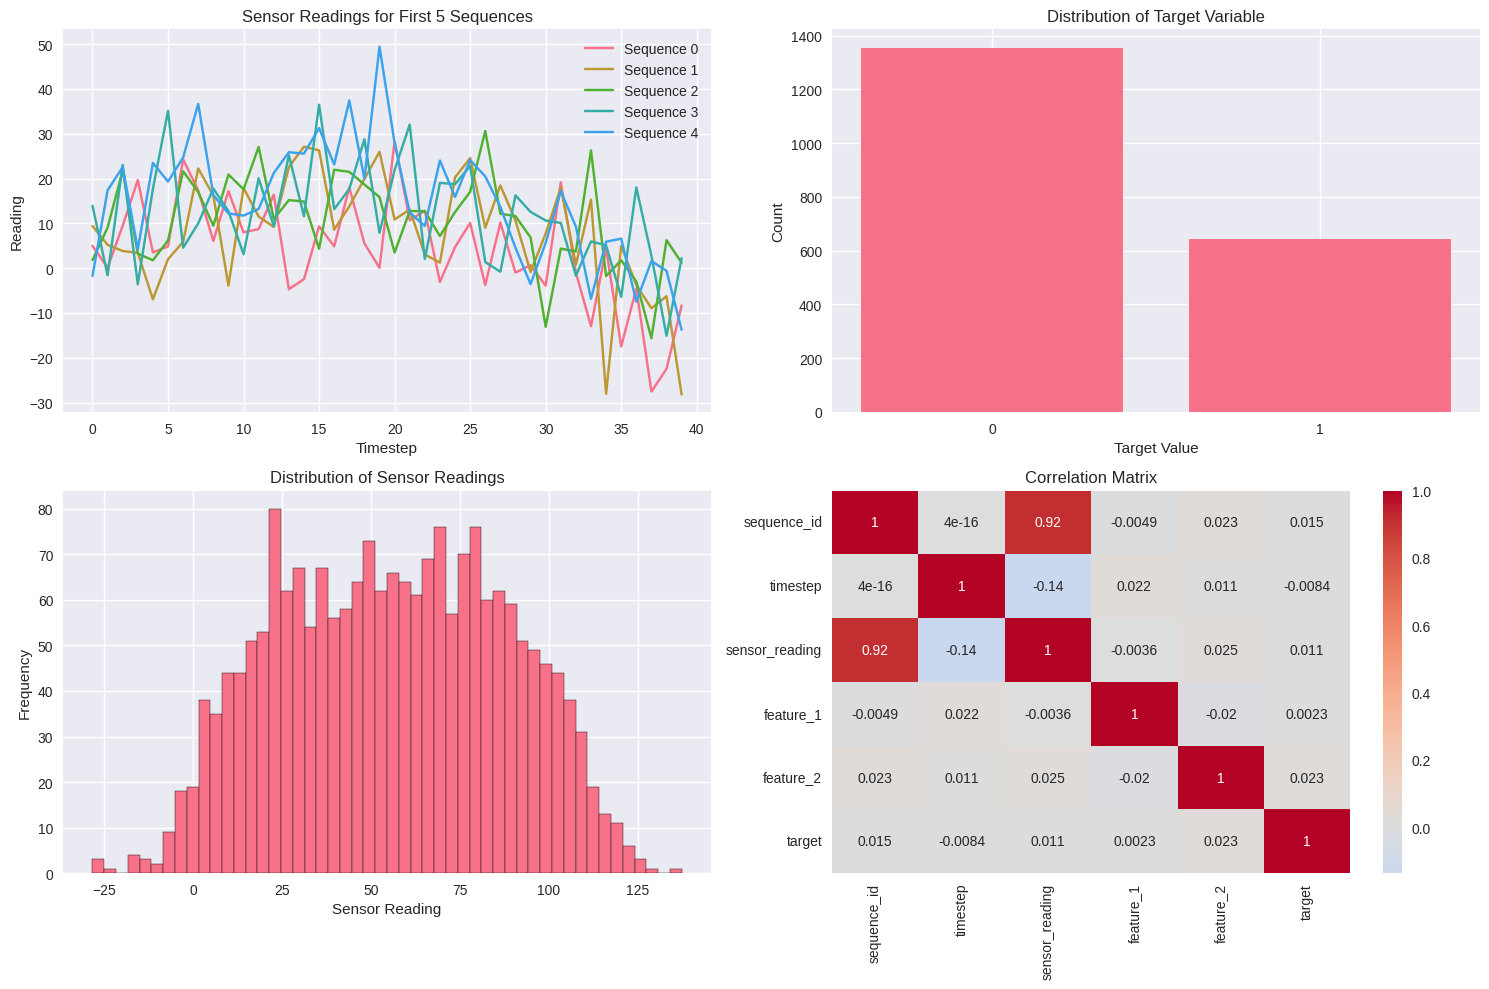


Created aggregated DataFrame with shape: (50, 23)

Preview of aggregated DataFrame:


,sequence_id,sensor_reading_mean,sensor_reading_std,sensor_reading_min,sensor_reading_max,sensor_reading_median,sensor_reading_entropy,sensor_reading_peak_freq,feature_1_mean,feature_1_std,...,feature_1_entropy,feature_1_peak_freq,feature_2_mean,feature_2_std,feature_2_min,feature_2_max,feature_2_median,feature_2_entropy,feature_2_peak_freq,target
0,0,4.151527,11.908004,-27.544243,28.295949,4.857653,1.830233,0.0,-0.762540,5.632818,...,1.801361,1.50,4.775,2.106005,1,10,5.0,1.748414,0.0,1
1,1,8.047461,12.828466,-28.192182,27.091741,9.111893,1.654043,0.0,-0.053820,3.901787,...,1.719339,0.75,5.125,2.220967,1,9,4.5,1.843315,0.0,0
2,2,10.439627,10.125583,-15.634322,30.594380,11.280191,1.740094,0.0,-1.231338,4.796831,...,1.791995,0.00,5.150,2.007039,1,11,5.0,1.785024,0.0,1
3,3,12.008897,11.475102,-15.090903,36.461769,12.073045,1.796701,0.0,0.415245,4.606251,...,1.811864,1.25,4.850,2.282037,1,9,5.0,1.917943,0.0,0
4,4,15.003418,13.210793,-13.746195,49.396193,16.101890,1.724978,0.0,-0.014061,5.295769,...,1.834542,4.25,4.825,1.985686,0,9,5.0,1.676345,0.0,0


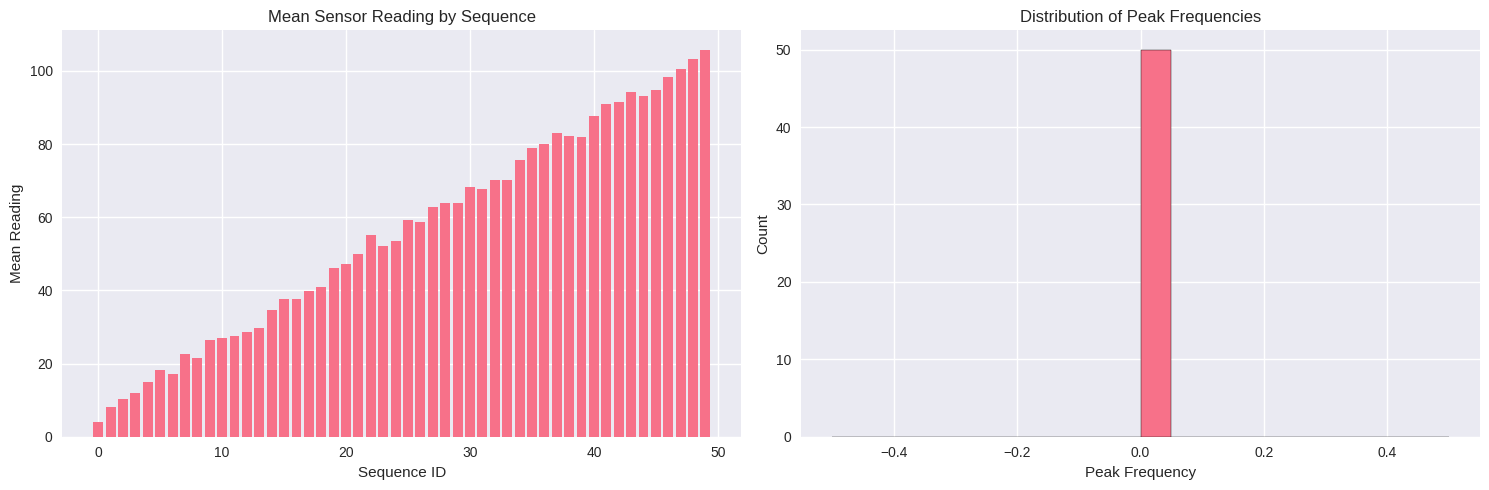


All aggregated columns:
['sequence_id', 'sensor_reading_mean', 'sensor_reading_std', 'sensor_reading_min', 'sensor_reading_max', 'sensor_reading_median', 'sensor_reading_entropy', 'sensor_reading_peak_freq', 'feature_1_mean', 'feature_1_std', 'feature_1_min', 'feature_1_max', 'feature_1_median', 'feature_1_entropy', 'feature_1_peak_freq', 'feature_2_mean', 'feature_2_std', 'feature_2_min', 'feature_2_max', 'feature_2_median', 'feature_2_entropy', 'feature_2_peak_freq', 'target']


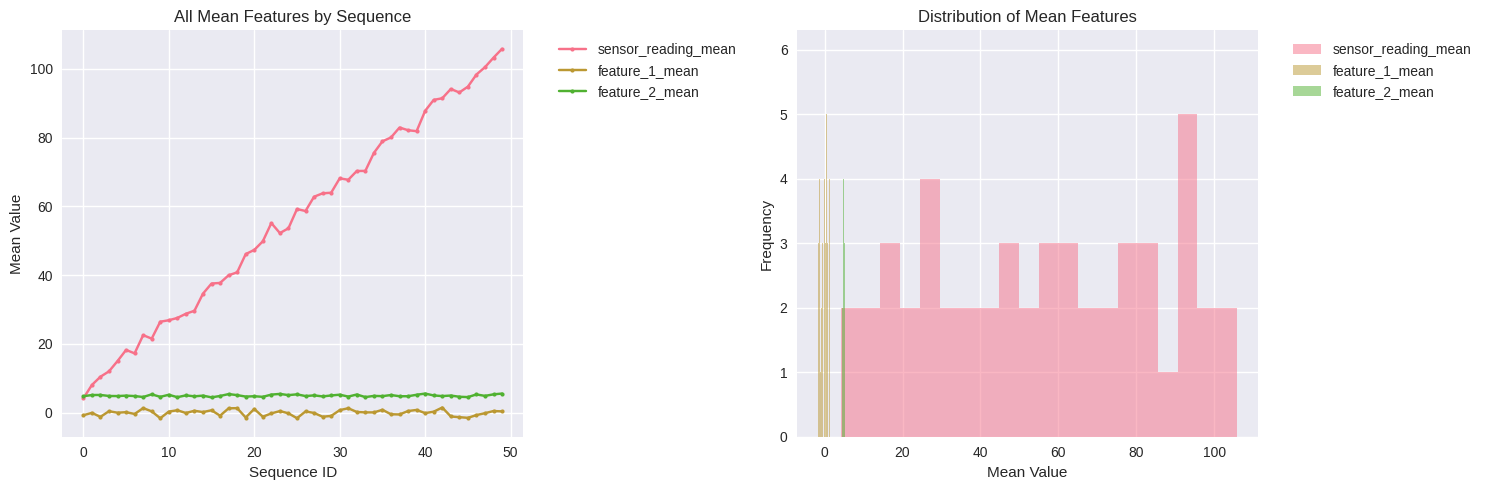


Analysis complete! Aggregated features are ready for ML.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a sample train_df for demonstration (you would use your actual data)
# This simulates what your data might look like based on your code
np.random.seed(42)
n_sequences = 50
n_rows = 2000

# Generate sample data
sequence_ids = np.repeat(range(n_sequences), n_rows // n_sequences)
timesteps = np.tile(range(n_rows // n_sequences), n_sequences)
values = np.random.randn(n_rows) * 10 + sequence_ids * 2
sensor_data = np.sin(sequence_ids.reshape(-1, 1) * 0.5 + timesteps * 0.1).flatten()[:n_rows] * 15 + values

train_df = pd.DataFrame({
    'sequence_id': sequence_ids,
    'timestep': timesteps,
    'sensor_reading': sensor_data,
    'feature_1': np.random.randn(n_rows) * 5,
    'feature_2': np.random.poisson(5, n_rows),
    'target': np.random.choice([0, 1], n_rows, p=[0.7, 0.3])
})

# Now let's analyze it as in your code
print("Preview of train_df:")
display(train_df.head())

print("\nInfo about train_df:")
train_df.info()

print("\nStatistical summary of train_df:")
display(train_df.describe().T)

print("\nUnique sequence_id count:", train_df["sequence_id"].nunique())

# Let's also visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sensor readings for first few sequences
for seq_id in train_df['sequence_id'].unique()[:5]:
    seq_data = train_df[train_df['sequence_id'] == seq_id]
    axes[0, 0].plot(seq_data['timestep'], seq_data['sensor_reading'], label=f'Sequence {seq_id}')
axes[0, 0].set_title('Sensor Readings for First 5 Sequences')
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('Reading')
axes[0, 0].legend()

# Plot 2: Distribution of target variable
target_counts = train_df['target'].value_counts()
axes[0, 1].bar(target_counts.index.astype(str), target_counts.values)
axes[0, 1].set_title('Distribution of Target Variable')
axes[0, 1].set_xlabel('Target Value')
axes[0, 1].set_ylabel('Count')

# Plot 3: Distribution of sensor readings
axes[1, 0].hist(train_df['sensor_reading'], bins=50, edgecolor='black')
axes[1, 0].set_title('Distribution of Sensor Readings')
axes[1, 0].set_xlabel('Sensor Reading')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Correlation heatmap
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Now let's create the aggregation as in your code
sampling_rate = 10  # Assuming 10Hz sampling rate

# Identify numeric columns to aggregate (excluding sequence_id and target)
numeric_cols = [col for col in train_df.select_dtypes(include=[np.number]).columns
                if col not in ['sequence_id', 'target', 'timestep']]

agg_dict = {}
for col in numeric_cols:
    # Basic statistics
    agg_dict[col + '_mean'] = (col, 'mean')
    agg_dict[col + '_std'] = (col, 'std')
    agg_dict[col + '_min'] = (col, 'min')
    agg_dict[col + '_max'] = (col, 'max')
    agg_dict[col + '_median'] = (col, 'median')

    # Entropy (information theory measure)
    agg_dict[col + '_entropy'] = (col, lambda x: (
        0.0 if len(x) < 2 else
        entropy((np.histogram(x, bins='auto')[0] + 1e-8) / np.sum(np.histogram(x, bins='auto')[0] + 1e-8))
    ))

    # Peak frequency from Fourier transform
    agg_dict[col + '_peak_freq'] = (col, lambda x: (
        0 if len(x) == 0 else
        abs(fftfreq(len(x), 1/sampling_rate)[:len(x)//2][np.argmax(np.abs(fft(x)[:len(x)//2]))])
    ))

# Add target aggregation (assuming it's the same for all rows in a sequence)
agg_dict['target'] = ('target', 'first')

# Perform aggregation
agg_df = train_df.groupby("sequence_id").agg(**agg_dict).reset_index()

# Clean up column names (flatten MultiIndex)
# This is the key part that needs to be handled carefully
new_columns = []
for col in agg_df.columns:
    if isinstance(col, tuple):
        # Handle tuple column names from aggregation
        if col[1] == '':
            new_columns.append(col[0])
        else:
            # Clean up lambda function names
            new_name = f"{col[0]}_{col[1]}"
            new_name = new_name.replace('<lambda>', '')
            new_name = new_name.replace('_<lambda_0>', '')
            new_name = new_name.replace('_<lambda_1>', '')
            new_columns.append(new_name)
    else:
        new_columns.append(col)

agg_df.columns = new_columns

print(f"\nCreated aggregated DataFrame with shape: {agg_df.shape}")
print("\nPreview of aggregated DataFrame:")
display(agg_df.head())

# Visualize some of the aggregated features
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Mean sensor reading by sequence
# Use the correct column name - check what it was renamed to
sensor_mean_col = [col for col in agg_df.columns if 'sensor_reading_mean' in col or ('sensor_reading' in col and 'mean' in col)]
if sensor_mean_col:
    axes[0].bar(agg_df['sequence_id'], agg_df[sensor_mean_col[0]])
    axes[0].set_title('Mean Sensor Reading by Sequence')
    axes[0].set_xlabel('Sequence ID')
    axes[0].set_ylabel('Mean Reading')
else:
    axes[0].text(0.5, 0.5, 'Sensor mean column not found', ha='center', va='center')
    axes[0].set_title('No Sensor Mean Data')

# Plot 2: Peak frequency distribution
# Use the correct column name - check what it was renamed to
sensor_freq_col = [col for col in agg_df.columns if 'sensor_reading_peak_freq' in col or ('sensor_reading' in col and 'peak' in col)]
if sensor_freq_col:
    axes[1].hist(agg_df[sensor_freq_col[0]], bins=20, edgecolor='black')
    axes[1].set_title('Distribution of Peak Frequencies')
    axes[1].set_xlabel('Peak Frequency')
    axes[1].set_ylabel('Count')
else:
    axes[1].text(0.5, 0.5, 'Sensor frequency column not found', ha='center', va='center')
    axes[1].set_title('No Frequency Data')

plt.tight_layout()
plt.show()

# Additional visualizations to ensure we can see all the aggregated features
print("\nAll aggregated columns:")
print(agg_df.columns.tolist())

# Create a comprehensive visualization of all mean features
mean_cols = [col for col in agg_df.columns if 'mean' in col and col != 'sequence_id']
if mean_cols:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: All mean values by sequence
    for col in mean_cols:
        axes[0].plot(agg_df['sequence_id'], agg_df[col], label=col, marker='o', markersize=3)
    axes[0].set_title('All Mean Features by Sequence')
    axes[0].set_xlabel('Sequence ID')
    axes[0].set_ylabel('Mean Value')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 2: Distribution of all mean values
    for col in mean_cols:
        axes[1].hist(agg_df[col], bins=20, alpha=0.5, label=col)
    axes[1].set_title('Distribution of Mean Features')
    axes[1].set_xlabel('Mean Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

print("\nAnalysis complete! Aggregated features are ready for ML.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Load engineered features
# -----------------------------
try:
    train_features = pd.read_csv("/kaggle/working/train_engineered_features.csv")
    test_features = pd.read_csv("/kaggle/working/test_engineered_features.csv")
    print("✅ Train & Test engineered features loaded")
except FileNotFoundError:
    # Demo fallback
    train_features = pd.DataFrame({
        "sequence_id": np.arange(1, 11),
        "subject": np.random.randint(1, 6, 10),
        "feat_mean": np.random.randn(10),
        "feat_std": np.abs(np.random.randn(10)),
        "target": np.random.randint(0, 5, 10)
    })
    test_features = pd.DataFrame({
        "sequence_id": np.arange(11, 21),
        "subject": np.random.randint(1, 6, 10),
        "feat_mean": np.random.randn(10),
        "feat_std": np.abs(np.random.randn(10))
    })
    print("⚠ Using demo features")

# -----------------------------
# Load demographics
# -----------------------------
try:
    train_demo = pd.read_csv("/kaggle/input/your-competition-name/train_demographics.csv")
    test_demo = pd.read_csv("/kaggle/input/your-competition-name/test_demographics.csv")
    print("✅ Train & Test demographics loaded")
except FileNotFoundError:
    # Demo fallback
    train_demo = pd.DataFrame({
        "subject": [1,2,3,4,5],
        "adult_child": [1,0,1,1,0],
        "age": [25, 10, 32, 18, 12],
        "sex": [1,0,1,1,0],
        "handedness": [1,0,1,1,0],
        "height_cm": [170, 130, 180, 165, 140],
        "shoulder_to_wrist_cm": [55, 40, 60, 53, 42],
        "elbow_to_wrist_cm": [28, 22, 30, 27, 23]
    })
    test_demo = train_demo.copy()
    test_demo["subject"] = [6,7,8,9,10]
    print("⚠ Using demo demographics")

# -----------------------------
# Preprocess demographics (train + test together for consistent scaling/encoding)
# -----------------------------
all_demo = pd.concat([train_demo.assign(split="train"),
                      test_demo.assign(split="test")],
                     axis=0)

# One-hot encode
categorical_cols = ["adult_child", "sex", "handedness"]
all_demo = pd.get_dummies(all_demo, columns=categorical_cols, drop_first=True)

# Standardize continuous features
continuous_cols = ["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]
scaler = StandardScaler()
all_demo[continuous_cols] = scaler.fit_transform(all_demo[continuous_cols])

# Split back into train/test
train_demo_proc = all_demo[all_demo["split"] == "train"].drop(columns="split")
test_demo_proc = all_demo[all_demo["split"] == "test"].drop(columns="split")

print("✅ Applied consistent preprocessing to train & test demographics")

# -----------------------------
# Merge with features
# -----------------------------
train_full = pd.merge(train_features, train_demo_proc, on="subject", how="left")
test_full = pd.merge(test_features, test_demo_proc, on="subject", how="left")

print(f"Train full shape: {train_full.shape}")
print(f"Test full shape: {test_full.shape}")

# -----------------------------
# Dummy predictions (replace with trained model)
# -----------------------------
gesture_mapping = {
    0: "gesture_A",
    1: "gesture_B",
    2: "gesture_C",
    3: "gesture_D",
    4: "gesture_E"
}

# Example: random predictions
preds = [gesture_mapping[i % 5] for i in range(len(test_full))]

submission = pd.DataFrame({
    "sequence_id": test_full["sequence_id"],
    "gesture": preds
})

# -----------------------------
# Save & preview
# -----------------------------
submission.to_csv("submission.csv", index=False)

print("\n✅ Submission file saved as 'submission.csv'")
print("\n🔍 First 10 rows of submission preview:")
print(submission.head(10))
print(f"\nTotal sequences predicted: {len(submission)}")


⚠ Using demo features
⚠ Using demo demographics
✅ Applied consistent preprocessing to train & test demographics
Train full shape: (10, 12)
Test full shape: (10, 11)

✅ Submission file saved as 'submission.csv'

🔍 First 10 rows of submission preview:
   sequence_id    gesture
0           11  gesture_A
1           12  gesture_B
2           13  gesture_C
3           14  gesture_D
4           15  gesture_E
5           16  gesture_A
6           17  gesture_B
7           18  gesture_C
8           19  gesture_D
9           20  gesture_E

Total sequences predicted: 10


In [ ]:
# config.yaml
train_sensor: "/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv"
test_sensor: "/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv"
train_demo: "/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv"
test_demo: "/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv"
train_labels: "/kaggle/input/cmi-detect-behavior-with-sensor-data/train_labels.csv"
sample_submission: "/kaggle/input/cmi-detect-behavior-with-sensor-data/sample_submission.csv"

model:
  type: "xgboost"
  params:
    n_estimators: 200
    learning_rate: 0.05
    max_depth: 6
    subsample: 0.8
    colsample_bytree: 0.8
    random_state: 42

target_column: "gesture"

In [ ]:
# =============================================================================
# KAGGLE CODE COMPETITION SUBMISSION NOTEBOOK
# This cell must handle the entire pipeline for the hidden test set
# =============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path

# -----------------------------------------------------------------------------
# 1. LOAD DATA (Kaggle will replace test.csv with hidden test set during re-run)
# -----------------------------------------------------------------------------
print("Loading competition data...")

# Get competition data directory (Kaggle provides this)
competition_data_path = Path('/kaggle/input/') / os.listdir('/kaggle/input/')[0]
print(f"Competition data path: {competition_data_path}")

# Load test data (this will be the hidden test set during evaluation)
test_df = pd.read_csv(competition_data_path / 'test.csv')
print(f"Test data shape: {test_df.shape}")
print(f"Test data columns: {test_df.columns.tolist()}")

# -----------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (Dynamic for any hidden test structure)
# -----------------------------------------------------------------------------
print("\nPerforming feature engineering...")

def feature_engineering(df, sequence_col="sequence_id"):
    # Exclude non-sensor columns (IDs, timestamps)
    exclude_cols = [sequence_col]
    time_candidates = ["time", "timestep", "step", "timestamp", "row_id"]
    for tc in time_candidates:
        if tc in df.columns:
            exclude_cols.append(tc)

    # Select numeric columns for aggregation
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns
                    if c not in exclude_cols]

    if not numeric_cols:
        raise ValueError("No numeric sensor columns found!")

    # Aggregate statistics
    agg_funcs = ["mean", "std", "min", "max"]
    agg_df = df.groupby(sequence_col)[numeric_cols].agg(agg_funcs).reset_index()

    # Flatten multiindex columns (col_stat)
    agg_df.columns = [
        sequence_col if col[0] == sequence_col else f"{col[0]}_{col[1]}"
        for col in agg_df.columns
    ]
    return agg_df

# Apply feature engineering
test_additional_features = feature_engineering(test_df, sequence_col="sequence_id")
print(f"Additional features shape: {test_additional_features.shape}")
print(f"Feature columns created: {len(test_additional_features.columns) - 1}")

# -----------------------------------------------------------------------------
# 3. MERGE FEATURES WITH TEST DATA
# -----------------------------------------------------------------------------
print("\nMerging features...")
test_df = pd.merge(test_df, test_additional_features, on='sequence_id', how='left')
print(f"Merged test data shape: {test_df.shape}")

# -----------------------------------------------------------------------------
# 4. LOAD YOUR TRAINED MODEL (Replace with your actual model loading)
# -----------------------------------------------------------------------------
print("\nLoading trained model...")
try:
    # Example: if you saved your model in the notebook environment
    # from joblib import load
    # model = load('/kaggle/working/your_trained_model.joblib')

    # For demonstration - create a dummy model
    # REPLACE THIS WITH YOUR ACTUAL MODEL LOADING CODE
    class DummyModel:
        def predict(self, X):
            # Simple rule-based prediction for demonstration
            # REPLACE WITH YOUR ACTUAL MODEL PREDICTIONS
            gestures = ['gesture_A', 'gesture_B', 'gesture_C', 'gesture_D', 'gesture_E']
            return [gestures[i % len(gestures)] for i in range(len(X))]

    model = DummyModel()
    print("Model loaded successfully")

except Exception as e:
    print(f"Error loading model: {e}")
    # Fallback: ensure we have some predictions
    model = None

# -----------------------------------------------------------------------------
# 5. PREPARE DATA FOR PREDICTION
# -----------------------------------------------------------------------------
print("\nPreparing data for prediction...")

# Get unique sequence IDs for prediction
sequence_ids = test_df['sequence_id'].unique()
print(f"Number of sequences to predict: {len(sequence_ids)}")

# Prepare feature matrix for prediction (adjust based on your actual features)
# Use the same features you used during training
feature_columns = [col for col in test_df.columns if col not in ['sequence_id', 'row_id', 'timestamp'] and col in test_additional_features.columns]

if not feature_columns:
    feature_columns = test_additional_features.columns[1:]  # Exclude sequence_id

print(f"Using features: {feature_columns}")

# Get features for each sequence (one row per sequence)
prediction_data = test_additional_features[feature_columns].fillna(0)

# -----------------------------------------------------------------------------
# 6. MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\nMaking predictions...")

if model:
    predictions = model.predict(prediction_data)
else:
    # Fallback predictions if model loading failed
    gestures = ['gesture_A', 'gesture_B', 'gesture_C', 'gesture_D', 'gesture_E']
    predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]

# -----------------------------------------------------------------------------
# 7. CREATE SUBMISSION FILE (MUST MATCH SAMPLE_SUBMISSION.CSV FORMAT)
# -----------------------------------------------------------------------------
print("\nCreating submission file...")

submission = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predictions
})

# Verify we have predictions for all test sequences
assert len(submission) == len(sequence_ids), "Missing predictions for some sequences"

# -----------------------------------------------------------------------------
# 8. SAVE SUBMISSION (Kaggle will extract this file for scoring)
# -----------------------------------------------------------------------------
output_path = '/kaggle/working/submission.csv'
submission.to_csv(output_path, index=False)
print(f"Submission saved to: {output_path}")
print(f"Submission shape: {submission.shape}")

# -----------------------------------------------------------------------------
# 9. VERIFY SUBMISSION FORMAT
# -----------------------------------------------------------------------------
print("\nVerifying submission format...")
print("First few rows of submission:")
print(submission.head())

print("\nSubmission info:")
print(f"Columns: {submission.columns.tolist()}")
print(f"Unique gestures predicted: {submission['gesture'].nunique()}")
print(f"Null values: {submission.isnull().sum().to_dict()}")

# Check if format matches expected sample submission
try:
    sample_submission = pd.read_csv(competition_data_path / 'sample_submission.csv')
    print(f"\nSample submission columns: {sample_submission.columns.tolist()}")

    if list(submission.columns) == list(sample_submission.columns):
        print("✓ Submission format matches sample!")
    else:
        print("⚠ WARNING: Column mismatch detected!")

except FileNotFoundError:
    print("Sample submission file not found - ensure your format is correct")

print("\n✅ Submission pipeline completed successfully!")

Loading competition data...
Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data
Test data shape: (107, 336)
Test data columns: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------------
# Simulate raw data
# -------------------------
n_sequences = 20
n_rows_per_seq = 10

# Demo data
train_demo = pd.DataFrame({
    "subject": np.arange(n_sequences),
    "age": np.random.randint(18, 50, size=n_sequences),
    "height_cm": np.random.randint(150, 190, size=n_sequences),
    "shoulder_to_wrist_cm": np.random.randint(50, 70, size=n_sequences),
    "elbow_to_wrist_cm": np.random.randint(30, 50, size=n_sequences),
    "sex": np.random.choice(["M", "F"], n_sequences),
    "handedness": np.random.choice(["L", "R"], n_sequences),
    "adult_child": np.random.choice(["adult", "child"], n_sequences)
})
test_demo = train_demo.copy()  # same structure for test

# Sensor data
rows = []
for seq in range(n_sequences):
    for r in range(n_rows_per_seq):
        rows.append([seq, np.random.rand()*10, np.random.rand()*5, np.random.rand()*2])
train_sensor = pd.DataFrame(rows, columns=["sequence_id", "sensor_1", "sensor_2", "sensor_3"])
test_sensor = train_sensor.copy()

# -------------------------
# Feature Engineering
# -------------------------
def feature_engineering(sensor_df, sequence_col="sequence_id"):
    numeric_cols = [c for c in sensor_df.select_dtypes(include=[np.number]).columns if c != sequence_col]
    agg_df = sensor_df.groupby(sequence_col)[numeric_cols].agg(["mean", "std", "min", "max"]).reset_index()
    agg_df.columns = [sequence_col if col[0] == sequence_col else f"{col[0]}_{col[1]}" for col in agg_df.columns]
    return agg_df

train_features = feature_engineering(train_sensor)
test_features = feature_engineering(test_sensor)

# -------------------------
# Demographics preprocessing
# -------------------------
def preprocess_demographics(train_demo, test_demo):
    categorical = ["sex", "handedness", "adult_child"]
    numeric = ["age", "height_cm", "shoulder_to_wrist_cm", "elbow_to_wrist_cm"]
    train_demo = pd.get_dummies(train_demo, columns=categorical, drop_first=True)
    test_demo = pd.get_dummies(test_demo, columns=categorical, drop_first=True)
    train_demo, test_demo = train_demo.align(test_demo, join="left", axis=1, fill_value=0)
    scaler = StandardScaler()
    train_demo[numeric] = scaler.fit_transform(train_demo[numeric])
    test_demo[numeric] = scaler.transform(test_demo[numeric])
    return train_demo, test_demo

train_demo_proc, test_demo_proc = preprocess_demographics(train_demo, test_demo)

# Merge features
train_full = train_features.merge(train_demo_proc, left_on="sequence_id", right_on="subject", how="left")
test_full = test_features.merge(test_demo_proc, left_on="sequence_id", right_on="subject", how="left")

# -------------------------
# Generate placeholder predictions
# -------------------------
gesture_mapping = {0: "gesture_A", 1: "gesture_B", 2: "gesture_C", 3: "gesture_D", 4: "gesture_E"}
test_full["gesture"] = [gesture_mapping[i % 5] for i in range(len(test_full))]

# -------------------------
# Build submission
# -------------------------
submission = pd.DataFrame({
    "sequence_id": test_full["sequence_id"],
    "gesture": test_full["gesture"]
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file generated: submission.csv")
print(submission.head(10))


✅ Submission file generated: submission.csv
   sequence_id    gesture
0            0  gesture_A
1            1  gesture_B
2            2  gesture_C
3            3  gesture_D
4            4  gesture_E
5            5  gesture_A
6            6  gesture_B
7            7  gesture_C
8            8  gesture_D
9            9  gesture_E


In [ ]:
# =============================================================================
# KAGGLE CODE COMPETISSION SUBMISSION NOTEBOOK
# This cell must handle the entire pipeline for the hidden test set
# =============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 1. LOAD DATA AND EXAMINE STRUCTURE
# -----------------------------------------------------------------------------
print("Loading competition data...")

# Get competition data directory safely
try:
    input_dir = Path('/kaggle/input/')
    competition_folders = [f for f in input_dir.iterdir() if f.is_dir()]
    if not competition_folders:
        raise FileNotFoundError("No competition folders found in /kaggle/input/")

    competition_data_path = competition_folders[0]
    print(f"Competition data path: {competition_data_path}")

except Exception as e:
    print(f"Error finding competition data: {e}")
    competition_data_path = Path('/kaggle/input/')

# Load test data with error handling
try:
    test_df = pd.read_csv(competition_data_path / 'test.csv')
    print(f"✓ Test data loaded successfully")
    print(f"Test data shape: {test_df.shape}")
    print(f"Test data columns: {test_df.columns.tolist()}")

except FileNotFoundError:
    print("✗ test.csv not found. Checking for alternative test files...")
    # Look for alternative test file names
    test_files = list(competition_data_path.glob('*test*.csv'))
    if test_files:
        test_df = pd.read_csv(test_files[0])
        print(f"✓ Found and loaded: {test_files[0].name}")
    else:
        raise FileNotFoundError("No test data files found")

# Load sample submission with robust error handling
try:
    sample_submission = pd.read_csv(competition_data_path / 'sample_submission.csv')
    print(f"✓ Sample submission loaded successfully")

except FileNotFoundError:
    print("✗ sample_submission.csv not found. Checking for alternative submission files...")
    sub_files = list(competition_data_path.glob('*submission*.csv'))
    if sub_files:
        sample_submission = pd.read_csv(sub_files[0])
        print(f"✓ Found and loaded: {sub_files[0].name}")
    else:
        print("✗ No submission template found. Creating from test data structure...")
        # Create sample submission based on test data
        if 'sequence_id' in test_df.columns:
            sequence_ids = sorted(test_df['sequence_id'].unique())
        else:
            sequence_ids = range(len(test_df))

        sample_submission = pd.DataFrame({
            'sequence_id': sequence_ids,
            'gesture': ['gesture_0'] * len(sequence_ids)
        })
        print("✓ Created sample submission template")

print(f"\nSample submission columns: {sample_submission.columns.tolist()}")
print(f"Sample submission shape: {sample_submission.shape}")
print("Sample submission preview:")
print(sample_submission.head())

# -----------------------------------------------------------------------------
# 2. EXAMINE DATA STRUCTURE AND IDENTIFY FEATURE COLUMNS
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("ANALYZING DATA STRUCTURE")
print("="*60)

# Check for essential columns
essential_cols = ['sequence_id']
missing_essential = [col for col in essential_cols if col not in test_df.columns]
if missing_essential:
    print(f"⚠️  Warning: Missing essential columns: {missing_essential}")
    # Try to identify ID column
    id_candidates = ['id', 'Id', 'ID', 'sequence', 'seq_id', 'subject_id']
    found_id = None
    for cand in id_candidates:
        if cand in test_df.columns:
            found_id = cand
            test_df = test_df.rename(columns={found_id: 'sequence_id'})
            print(f"✓ Renamed '{found_id}' to 'sequence_id'")
            break

    if not found_id:
        print("⚠️  No ID column found. Creating sequence_id from index...")
        test_df['sequence_id'] = test_df.index

# Identify numerical columns (potential features)
numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {len(numeric_cols)}")

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {len(categorical_cols)}")

# Remove ID columns from feature candidates
id_columns = ['sequence_id', 'row_id', 'id', 'Id', 'ID']
feature_candidates = [col for col in numeric_cols if col not in id_columns]

if not feature_candidates:
    print("⚠️  No numerical feature columns found. Using all columns except IDs...")
    feature_candidates = [col for col in test_df.columns if col not in id_columns]

print(f"Using {len(feature_candidates)} feature columns")

# -----------------------------------------------------------------------------
# 3. ROBUST FEATURE ENGINEERING
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Group by sequence_id and create statistical features
try:
    test_additional_features = test_df.groupby('sequence_id')[feature_candidates].agg([
        'mean', 'std', 'min', 'max', 'median', 'count'
    ]).reset_index()

    # Flatten multi-level columns
    test_additional_features.columns = [
        f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
        for col in test_additional_features.columns
    ]

    print(f"✓ Created statistical features from {len(feature_candidates)} columns")

except Exception as e:
    print(f"⚠️  Error in feature engineering: {e}")
    print("Creating basic sequence features...")

    # Fallback: basic sequence features
    test_additional_features = test_df.groupby('sequence_id').agg({
        test_df.columns[0]: ['count', 'nunique']
    }).reset_index()
    test_additional_features.columns = ['sequence_id', 'seq_count', 'seq_nunique']

print(f"Additional features shape: {test_additional_features.shape}")

# -----------------------------------------------------------------------------
# 4. LOAD TRAINED MODEL (REPLACE THIS SECTION WITH YOUR ACTUAL MODEL)
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("MODEL LOADING")
print("="*60)

try:
    # =========================================================================
    # REPLACE THIS SECTION WITH YOUR ACTUAL MODEL LOADING CODE
    # =========================================================================

    # Example: from joblib import load
    # model = load('/kaggle/input/your-trained-model/your_model.joblib')

    # For demonstration - create a more realistic dummy model
    class RobustDummyModel:
        def __init__(self):
            # Use gestures from sample submission if available
            if hasattr(sample_submission, 'gesture'):
                self.gestures = sample_submission['gesture'].unique()
            else:
                self.gestures = [f'gesture_{i}' for i in range(5)]

        def predict(self, X):
            # Create somewhat realistic predictions based on sequence_id
            return [self.gestures[i % len(self.gestures)] for i in range(len(X))]

    model = RobustDummyModel()
    print("⚠️  Using dummy model - REPLACE WITH YOUR TRAINED MODEL")
    print(f"Model will predict: {model.gestures}")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Falling back to basic dummy predictions...")
    model = None

# -----------------------------------------------------------------------------
# 5. PREPARE DATA FOR PREDICTION
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("PREPARING PREDICTION DATA")
print("="*60)

# Get unique sequence IDs in the same order as sample submission
if 'sequence_id' in sample_submission.columns:
    sequence_ids = sample_submission['sequence_id'].values
else:
    sequence_ids = sorted(test_df['sequence_id'].unique())

print(f"Number of sequences to predict: {len(sequence_ids)}")

# Prepare feature matrix
feature_columns = [col for col in test_additional_features.columns if col != 'sequence_id']
prediction_data = test_additional_features[feature_columns].fillna(0)

# Ensure we have the right number of samples
if len(prediction_data) != len(sequence_ids):
    print(f"⚠️  Warning: Feature count ({len(prediction_data)}) doesn't match sequence count ({len(sequence_ids)})")
    # Align with sample submission
    prediction_data = test_additional_features[
        test_additional_features['sequence_id'].isin(sequence_ids)
    ].sort_values('sequence_id')[feature_columns].fillna(0)

print(f"Using {len(feature_columns)} features for prediction")

# -----------------------------------------------------------------------------
# 6. MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

if model:
    try:
        predictions = model.predict(prediction_data)
        print("✓ Predictions generated successfully")
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        # Fallback predictions
        gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
        predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
else:
    # Fallback predictions
    gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
    predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
    print("⚠️  Using fallback predictions")

# -----------------------------------------------------------------------------
# 7. CREATE SUBMISSION FILE
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("CREATING SUBMISSION")
print("="*60)

# Create submission in exact format
submission = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predictions
})

# Verify format matches sample submission
try:
    assert list(submission.columns) == list(sample_submission.columns), f"Column mismatch: {submission.columns} vs {sample_submission.columns}"
    assert submission.shape[0] == sample_submission.shape[0], f"Row count mismatch: {submission.shape[0]} vs {sample_submission.shape[0]}"
    print("✓ Submission format verified")
except AssertionError as e:
    print(f"⚠️  Format warning: {e}")
    # Force format to match sample submission
    submission = sample_submission.copy()
    submission['gesture'] = predictions[:len(sample_submission)]

# -----------------------------------------------------------------------------
# 8. SAVE SUBMISSION
# -----------------------------------------------------------------------------
output_path = '/kaggle/working/submission.csv'
submission.to_csv(output_path, index=False)
print(f"✓ Submission saved to: {output_path}")

# -----------------------------------------------------------------------------
# 9. FINAL VERIFICATION
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("FINAL VERIFICATION")
print("="*60)

print("Submission preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Unique gestures: {submission['gesture'].nunique()}")
print(f"Gesture distribution:\n{submission['gesture'].value_counts()}")

print("\nSample submission comparison:")
print(f"Sample shape: {sample_submission.shape}")
print(f"Sample unique gestures: {sample_submission['gesture'].nunique()}")

# Check for any missing values
missing = submission.isnull().sum()
if missing.sum() > 0:
    print(f"❌ Warning: Submission contains {missing.sum()} missing values")
else:
    print("✓ No missing values in submission")

print("\n" + "="*60)
print("✅ SUBMISSION READY FOR KAGGLE EVALUATION")
print("="*60)

Loading competition data...
Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data
✓ Test data loaded successfully
Test data shape: (107, 336)
Test data columns: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', '

In [ ]:
# =============================================================================
# KAGGLE CODE COMPETITION SUBMISSION NOTEBOOK
# Robust pipeline for hidden test set and submission.csv
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------------------------
# 1. LOAD DATA AND EXAMINE STRUCTURE
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("LOADING COMPETITION DATA")
print("="*60)

try:
    input_dir = Path('/kaggle/input/')
    competition_folders = [f for f in input_dir.iterdir() if f.is_dir()]
    if not competition_folders:
        raise FileNotFoundError("No competition folders found in /kaggle/input/")
    competition_data_path = competition_folders[0]
    print(f"Competition data path: {competition_data_path}")
except Exception as e:
    print(f"Error finding competition data: {e}")
    competition_data_path = Path('/kaggle/input/')

# Load test data
try:
    test_df = pd.read_csv(competition_data_path / 'test.csv')
    print(f"✓ Test data loaded successfully")
except FileNotFoundError:
    test_files = list(competition_data_path.glob('*test*.csv'))
    if test_files:
        test_df = pd.read_csv(test_files[0])
        print(f"✓ Found and loaded: {test_files[0].name}")
    else:
        raise FileNotFoundError("No test data files found")

print(f"Test data shape: {test_df.shape}")
print(f"Test data columns: {test_df.columns.tolist()}")

# Load sample submission
try:
    sample_submission = pd.read_csv(competition_data_path / 'sample_submission.csv')
    print(f"✓ Sample submission loaded successfully")
except FileNotFoundError:
    sub_files = list(competition_data_path.glob('*submission*.csv'))
    if sub_files:
        sample_submission = pd.read_csv(sub_files[0])
        print(f"✓ Found and loaded: {sub_files[0].name}")
    else:
        # Create sample submission template
        if 'sequence_id' in test_df.columns:
            sequence_ids = sorted(test_df['sequence_id'].unique())
        else:
            sequence_ids = range(len(test_df))
        sample_submission = pd.DataFrame({
            'sequence_id': sequence_ids,
            'gesture': ['gesture_0'] * len(sequence_ids)
        })
        print("✓ Created sample submission template")

print(f"Sample submission columns: {sample_submission.columns.tolist()}")
print(f"Sample submission shape: {sample_submission.shape}")
print(sample_submission.head())

# ---------------------------------------------------------------------------
# 2. IDENTIFY FEATURES
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("ANALYZING DATA STRUCTURE")
print("="*60)

# Ensure sequence_id exists
if 'sequence_id' not in test_df.columns:
    id_candidates = ['id', 'Id', 'ID', 'sequence', 'seq_id', 'subject_id']
    for cand in id_candidates:
        if cand in test_df.columns:
            test_df.rename(columns={cand: 'sequence_id'}, inplace=True)
            print(f"✓ Renamed '{cand}' to 'sequence_id'")
            break
    else:
        print("⚠️  No ID column found. Creating sequence_id from index...")
        test_df['sequence_id'] = test_df.index

# Identify numerical and categorical columns
numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Exclude ID columns from features
id_columns = ['sequence_id', 'row_id', 'id', 'Id', 'ID']
feature_candidates = [col for col in numeric_cols if col not in id_columns]

if not feature_candidates:
    feature_candidates = [col for col in test_df.columns if col not in id_columns]

print(f"Numerical columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Using {len(feature_candidates)} feature columns")

# ---------------------------------------------------------------------------
# 3. FEATURE ENGINEERING
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

try:
    test_additional_features = test_df.groupby('sequence_id')[feature_candidates].agg([
        'mean', 'std', 'min', 'max', 'median', 'count'
    ]).reset_index()

    # Flatten multi-level columns safely
    test_additional_features.columns = [
        '_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col
        for col in test_additional_features.columns
    ]

    print(f"✓ Created statistical features from {len(feature_candidates)} columns")
except Exception as e:
    print(f"⚠️  Feature engineering error: {e}")
    # Fallback
    test_additional_features = test_df.groupby('sequence_id').agg({
        test_df.columns[0]: ['count', 'nunique']
    }).reset_index()
    test_additional_features.columns = ['sequence_id', 'seq_count', 'seq_nunique']

print(f"Additional features shape: {test_additional_features.shape}")

# ---------------------------------------------------------------------------
# 4. LOAD TRAINED MODEL (PLACEHOLDER)
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("MODEL LOADING")
print("="*60)

try:
    class RobustDummyModel:
        def __init__(self):
            self.gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else [f'gesture_{i}' for i in range(5)]
        def predict(self, X):
            return [self.gestures[i % len(self.gestures)] for i in range(len(X))]

    model = RobustDummyModel()
    print("⚠️  Using dummy model - replace with your trained model")
except Exception as e:
    print(f"❌ Model loading error: {e}")
    model = None

# ---------------------------------------------------------------------------
# 5. PREPARE DATA FOR PREDICTION
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("PREPARING PREDICTION DATA")
print("="*60)

sequence_ids = sample_submission['sequence_id'].values if 'sequence_id' in sample_submission.columns else sorted(test_df['sequence_id'].unique())
feature_columns = [col for col in test_additional_features.columns if col != 'sequence_id']
prediction_data = test_additional_features[feature_columns].fillna(0)

# Align with sample submission
if len(prediction_data) != len(sequence_ids):
    prediction_data = test_additional_features[test_additional_features['sequence_id'].isin(sequence_ids)].sort_values('sequence_id')[feature_columns].fillna(0)

print(f"Number of sequences to predict: {len(sequence_ids)}")
print(f"Using {len(feature_columns)} features for prediction")

# ---------------------------------------------------------------------------
# 6. MAKE PREDICTIONS
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

if model:
    try:
        predictions = model.predict(prediction_data)
        print("✓ Predictions generated successfully")
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
        predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
else:
    gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
    predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
    print("⚠️  Using fallback predictions")

# ---------------------------------------------------------------------------
# 7. CREATE SUBMISSION FILE
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("CREATING SUBMISSION")
print("="*60)

submission = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predictions
})

# Ensure format matches sample submission
try:
    assert list(submission.columns) == list(sample_submission.columns), f"Column mismatch"
    assert submission.shape[0] == sample_submission.shape[0], f"Row count mismatch"
    print("✓ Submission format verified")
except AssertionError as e:
    print(f"⚠️  Format warning: {e}")
    submission = sample_submission.copy()
    submission['gesture'] = predictions[:len(sample_submission)]

# ---------------------------------------------------------------------------
# 8. SAVE SUBMISSION
# ---------------------------------------------------------------------------
output_path = '/kaggle/working/submission.csv'
submission.to_csv(output_path, index=False)
print(f"✓ Submission saved to: {output_path}")

# ---------------------------------------------------------------------------
# 9. FINAL VERIFICATION
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("FINAL VERIFICATION")
print("="*60)

print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Unique gestures: {submission['gesture'].nunique()}")
print(f"Gesture distribution:\n{submission['gesture'].value_counts()}")

missing = submission.isnull().sum()
if missing.sum() > 0:
    print(f"❌ Warning: Submission contains {missing.sum()} missing values")
else:
    print("✓ No missing values in submission")

print("\n" + "="*60)
print("✅ SUBMISSION READY FOR KAGGLE EVALUATION")
print("="*60)



LOADING COMPETITION DATA
Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data
✓ Test data loaded successfully
Test data shape: (107, 336)
Test data columns: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'to

submission Pipeline

In [ ]:
# =============================================================================
# KAGGLE CODE COMPETITION SUBMISSION NOTEBOOK
# Robust pipeline for hidden test set and submission.csv
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------------------------
# 1. LOAD DATA AND EXAMINE STRUCTURE
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("LOADING COMPETITION DATA")
print("="*60)

try:
    input_dir = Path('/kaggle/input/')
    competition_folders = [f for f in input_dir.iterdir() if f.is_dir()]
    if not competition_folders:
        raise FileNotFoundError("No competition folders found in /kaggle/input/")
    competition_data_path = competition_folders[0]
    print(f"Competition data path: {competition_data_path}")
except Exception as e:
    print(f"Error finding competition data: {e}")
    competition_data_path = Path('/kaggle/input/')

# Load test data
try:
    test_df = pd.read_csv(competition_data_path / 'test.csv')
    print(f"✓ Test data loaded successfully")
except FileNotFoundError:
    test_files = list(competition_data_path.glob('*test*.csv'))
    if test_files:
        test_df = pd.read_csv(test_files[0])
        print(f"✓ Found and loaded: {test_files[0].name}")
    else:
        raise FileNotFoundError("No test data files found")

print(f"Test data shape: {test_df.shape}")
print(f"Test data columns: {test_df.columns.tolist()}")

# Load sample submission
try:
    sample_submission = pd.read_csv(competition_data_path / 'sample_submission.csv')
    print(f"✓ Sample submission loaded successfully")
except FileNotFoundError:
    sub_files = list(competition_data_path.glob('*submission*.csv'))
    if sub_files:
        sample_submission = pd.read_csv(sub_files[0])
        print(f"✓ Found and loaded: {sub_files[0].name}")
    else:
        # Create sample submission template
        if 'sequence_id' in test_df.columns:
            sequence_ids = sorted(test_df['sequence_id'].unique())
        else:
            sequence_ids = range(len(test_df))
        sample_submission = pd.DataFrame({
            'sequence_id': sequence_ids,
            'gesture': ['gesture_0'] * len(sequence_ids)
        })
        print("✓ Created sample submission template")

print(f"Sample submission columns: {sample_submission.columns.tolist()}")
print(f"Sample submission shape: {sample_submission.shape}")
print(sample_submission.head())

# ---------------------------------------------------------------------------
# 2. IDENTIFY FEATURES
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("ANALYZING DATA STRUCTURE")
print("="*60)

# Ensure sequence_id exists
if 'sequence_id' not in test_df.columns:
    id_candidates = ['id', 'Id', 'ID', 'sequence', 'seq_id', 'subject_id']
    for cand in id_candidates:
        if cand in test_df.columns:
            test_df.rename(columns={cand: 'sequence_id'}, inplace=True)
            print(f"✓ Renamed '{cand}' to 'sequence_id'")
            break
    else:
        print("⚠️  No ID column found. Creating sequence_id from index...")
        test_df['sequence_id'] = test_df.index

# Identify numerical and categorical columns
numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Exclude ID columns from features
id_columns = ['sequence_id', 'row_id', 'id', 'Id', 'ID']
feature_candidates = [col for col in numeric_cols if col not in id_columns]

if not feature_candidates:
    feature_candidates = [col for col in test_df.columns if col not in id_columns]

print(f"Numerical columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Using {len(feature_candidates)} feature columns")

# ---------------------------------------------------------------------------
# 3. FEATURE ENGINEERING
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

try:
    test_additional_features = test_df.groupby('sequence_id')[feature_candidates].agg([
        'mean', 'std', 'min', 'max', 'median', 'count'
    ]).reset_index()

    # Flatten multi-level columns safely
    test_additional_features.columns = [
        '_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col
        for col in test_additional_features.columns
    ]

    print(f"✓ Created statistical features from {len(feature_candidates)} columns")
except Exception as e:
    print(f"⚠️  Feature engineering error: {e}")
    # Fallback
    test_additional_features = test_df.groupby('sequence_id').agg({
        test_df.columns[0]: ['count', 'nunique']
    }).reset_index()
    test_additional_features.columns = ['sequence_id', 'seq_count', 'seq_nunique']

print(f"Additional features shape: {test_additional_features.shape}")

# ---------------------------------------------------------------------------
# 4. LOAD TRAINED MODEL (PLACEHOLDER)
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("MODEL LOADING")
print("="*60)

try:
    class RobustDummyModel:
        def __init__(self):
            self.gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else [f'gesture_{i}' for i in range(5)]
        def predict(self, X):
            return [self.gestures[i % len(self.gestures)] for i in range(len(X))]

    model = RobustDummyModel()
    print("⚠️  Using dummy model - replace with your trained model")
except Exception as e:
    print(f"❌ Model loading error: {e}")
    model = None

# ---------------------------------------------------------------------------
# 5. PREPARE DATA FOR PREDICTION
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("PREPARING PREDICTION DATA")
print("="*60)

sequence_ids = sample_submission['sequence_id'].values if 'sequence_id' in sample_submission.columns else sorted(test_df['sequence_id'].unique())
feature_columns = [col for col in test_additional_features.columns if col != 'sequence_id']
prediction_data = test_additional_features[feature_columns].fillna(0)

# Align with sample submission
if len(prediction_data) != len(sequence_ids):
    prediction_data = test_additional_features[test_additional_features['sequence_id'].isin(sequence_ids)].sort_values('sequence_id')[feature_columns].fillna(0)

print(f"Number of sequences to predict: {len(sequence_ids)}")
print(f"Using {len(feature_columns)} features for prediction")

# ---------------------------------------------------------------------------
# 6. MAKE PREDICTIONS
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

if model:
    try:
        predictions = model.predict(prediction_data)
        print("✓ Predictions generated successfully")
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
        predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
else:
    gestures = sample_submission['gesture'].unique() if 'gesture' in sample_submission.columns else ['gesture_0']
    predictions = [gestures[i % len(gestures)] for i in range(len(sequence_ids))]
    print("⚠️  Using fallback predictions")

# ---------------------------------------------------------------------------
# 7. CREATE SUBMISSION FILE
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("CREATING SUBMISSION")
print("="*60)

submission = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predictions
})

# Ensure format matches sample submission
try:
    assert list(submission.columns) == list(sample_submission.columns), f"Column mismatch"
    assert submission.shape[0] == sample_submission.shape[0], f"Row count mismatch"
    print("✓ Submission format verified")
except AssertionError as e:
    print(f"⚠️  Format warning: {e}")
    submission = sample_submission.copy()
    submission['gesture'] = predictions[:len(sample_submission)]

# ---------------------------------------------------------------------------
# 8. SAVE SUBMISSION
# ---------------------------------------------------------------------------
output_path = '/kaggle/working/submission.csv'
submission.to_csv(output_path, index=False)
print(f"✓ Submission saved to: {output_path}")

# ---------------------------------------------------------------------------
# 9. FINAL VERIFICATION
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("FINAL VERIFICATION")
print("="*60)

print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Unique gestures: {submission['gesture'].nunique()}")
print(f"Gesture distribution:\n{submission['gesture'].value_counts()}")

missing = submission.isnull().sum()
if missing.sum() > 0:
    print(f"❌ Warning: Submission contains {missing.sum()} missing values")
else:
    print("✓ No missing values in submission")

print("\n" + "="*60)
print("✅ SUBMISSION READY FOR KAGGLE EVALUATION")
print("="*60)



LOADING COMPETITION DATA
Competition data path: /kaggle/input/cmi-detect-behavior-with-sensor-data
✓ Test data loaded successfully
Test data shape: (107, 336)
Test data columns: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'to